In [1]:
import routines as r
import importlib
importlib.reload(r) # to be able to modify routines.py and use the new version of the file

import matplotlib.pyplot as plt ; import numpy as np
import csv ; import h5py ; import pandas as pd
import os ; import sys ; import time
import random
import tensorflow as tf
from tensorflow.keras  import regularizers, optimizers, layers, losses, Model
from tensorflow.keras.models import load_model

datafolder='/home/s/Downloads/' #folder where data is
path0='/home/s/Desktop'
markerslist=['o-','x-','>-','s-','*-','<-','p-','+-','h-','d-','^-']
markerslist2=['o','x','>','s','*','<','p','+','h','d','^']

In [2]:
class Data:
  def __init__(self,name,path,L):
    self.name=name
    self.path=path
    self.L=L
  def load_data(self,label,normalization_flag):
    # label=1 removes the label if it is there. label=0 does nothing.
    t_i=time.time() #initial time
    print('loading data set '+str(self.name))
    foo=[]#list of spin configurations
    var=[]#list of temperatures
    with open(self.path, newline='\n') as csvfile: #reads data file
        csv_reader = csv.reader(csvfile, delimiter=' ')
        if (label): # if there is a label, i remove it. it is the first element of each line
          for line in csv_reader:
            var.append(line.pop(1))
            foo.append(line[label:-1]) # the -1 removes a white space
        else:
          for line in csv_reader:
            var.append(line.pop(0))
            foo.append(line[:-1]) # the -1 removes a white space
    self.data=np.array(foo) 
    self.T=np.array(var)
    self.T=self.T.astype(float)
    self.data_format(normalization_flag)
    delta_t=round((time.time()-t_i)/60,1)
    print('\n'+'this took '+str(delta_t)+' minutes')
    return

  def data_format(self,normalization_flag):
    self.data=self.data.astype(float)
    self.T=self.T.astype(float)
    if (normalization_flag):
      self.data=(self.data+1.)/2 #normalization
    return
  

class AEFullyConnected(Model):
  def __init__(self,NL,L,rl2, **kwargs):
    self.NL=NL #Number of neurons in the latent space
    self.L=L # linear size of the sistem
    self.rl2=rl2 # l2 regularizer
    super(AEFullyConnected, self).__init__(**kwargs)
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(self.L* self.L)), 
      layers.Dense(name='latent',units=self.NL,activation='sigmoid',kernel_regularizer=tf.keras.regularizers.l2(self.rl2))
      ])
    self.decoder = tf.keras.Sequential([
      #if (Dropoutflag):
      #  layers.Dropout(DO)
      layers.Dense(name='final',units=self.L*self.L,activation='sigmoid',),
      ])
  
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded
  
class Training:
  def __init__(self,autoencoder,n_epochs,BS,VS,lr,training_data,save_model_flag,modelfolder,
              name_encoder,name_decoder):
    self.n_epochs=n_epochs #number of epochs
    self.BS=BS #batch size
    self.lr=lr #learning_rate
    self.VS=VS #validation split
    self.training_data=training_data
    self.save_model_flag=save_model_flag # save_model_flag=1 if you want to save the trained model
    self.modelfolder=modelfolder #folder where the trained model will go in saving
    self.autoencoder=autoencoder #initialized autoencoder
    self.name_encoder=name_encoder
    self.name_decoder=name_decoder

  def remove_temperatures_training(self,T_list,T_cut):
    T_train_list=[]
    new_training_data=[]
    for i in range(len(self.training_data)):
      if (T_list[i]>T_cut):
        T_train_list.append(T_list[i])
        new_training_data.append(self.training_data[i])
    self.training_data=np.array(new_training_data)
    self.training_temperatures=np.array(T_train_list)
    print('training_data shape is', np.shape(new_training_data))
    return
  
  def export_trained_model(self):
    modelname_encoder=self.modelfolder+self.name_encoder
    modelname_decoder=self.modelfolder+self.name_decoder
    autoencoder.encoder.save(modelname_encoder)
    autoencoder.decoder.save(modelname_decoder)
    return
    
  def run(self):
    t_i=time.time()
    opt = optimizers.Adam(learning_rate=self.lr)
    autoencoder.compile(optimizer=opt,loss=losses.MeanSquaredError())
    history = autoencoder.fit(self.training_data,self.training_data, 
              epochs=self.n_epochs, 
              batch_size=self.BS,
              validation_split=self.VS,
              shuffle=True)
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"],'--', label="Validation Loss")
    plt.legend()
    plt.savefig(self.modelfolder+self.name_encoder+'history.png', bbox_inches='tight')
    plt.show()
    
    if (self.save_model_flag):
      self.export_trained_model()
      
    delta_t=round((time.time()-t_i)/60.,1)
    print('this took '+str(delta_t)+' minutes')
    return

#for fancy plotting
plt.rcParams['xtick.labelsize']=18
plt.rcParams['ytick.labelsize']=18
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams.update({'figure.autolayout': True})

In [3]:
#name='<Ising antiferromagnet on the honeycomb lattice>'
#path=datafolder+'Honeycomb_J2_0.txt';labelflag=0

##normalization_flag=1 normalizes spins to 0 and 1. normalization_flag=0 let spins to be +1 and -1

normalization_flag=1
Tc=2.27 #thermodynamic limit

L=30
name='<Ising ferromagnet on the '+str(L)+'x'+str(L)+' square lattice>'
path=datafolder+'Square_ferro_2.txt';labelflag=1
d=Data(name,path,L) #data object
d.load_data(labelflag,normalization_flag) #loads data
d.n_T=200
d.n_Tc=98
d.mTc=[0.5446166666666662, 0.011440611851853077]
d.ETc=[-1.3584666666666676 , 0.04438539009259346]

loading data set <Ising ferromagnet on the 30x30 square lattice>

this took 0.6 minutes


In [4]:
#Flags
AEflag=0 #0 means AEFullyConnected #1 means AE_FC_1_hidden
Dropoutflag=0
train_flag=0
save_model_flag=1 # 1 to save trained model and 0 to not save trained model
rand_flag=0 #random training data



#NL_list=[32+4*i for i in range(35)] # number of neurons in the latent space
#NL_list=[2**n for n in range(1,11)] # number of neurons in the latent space
#T_cut_list=[1.5,2.0,2.5,3.0,3.5]
#NL_list=[12,20,24,28]
#T_cut_list=[2.6,2.7,2.8,2.9]
NL_list=[128]
T_cut_list=[0]

#Random training data generator:
if rand_flag:
  training_data=np.array([np.random.randint(2,size=L*L) for i in range(300000)])
  print(np.shape(training_data))
  training_temperatures=[0 for x in training_data]
  T_cut_list=[0]
  
  
print('T_cut_list:', T_cut_list)
print('NL_list:', NL_list)
for NL in NL_list:
  if (AEflag==0):
    #training parameters
    if rand_flag:
      n_epochs=10
    else:
      n_epochs=50
    BS=512 #batch size
    lr=1E-3 #learning rate
    rl2=0 #l2 regularizer
    VS=.1 #validation split (a fraction of the training data)
    N_train=60000 #training_split
    if rand_flag==0:
      training_data=d.data[:N_train]
      training_temperatures=d.T[:N_train]
    hyperparameters_txt='/L'+str(L)+'/NL'+str(NL)+'/DO'+str(Dropoutflag)+'/rl2'+str(rl2)+\
    '/BS'+str(BS)+'/epochs'+str(n_epochs)+'/lr'+str(lr)+'/'
    modelfolder=path0+'/models'+hyperparameters_txt #folder where the models will be saved
    os.makedirs(modelfolder, exist_ok=True)
  ##
  if train_flag:
    for T_cut in T_cut_list:
      if (AEflag==0):
        autoencoder=AEFullyConnected(NL,L,rl2) # reinitialices parameters
      name_encoder='trained_encoder_T'+"{:.1f}".format(T_cut)+'.h5'
      name_decoder='trained_decoder_T'+"{:.1f}".format(T_cut)+'.h5'
      if (T_cut>=0 and rand_flag==0):
        training_data,training_temperatures=r.unison_shuffled_copies(training_data,training_temperatures)
      training=Training(autoencoder,n_epochs,BS,VS,lr,training_data,save_model_flag,modelfolder,
                       name_encoder,name_decoder)
      if (T_cut>0):
        training.remove_temperatures_training(training_temperatures,T_cut)
      training.run()
    autoencoder.encoder.summary()
    autoencoder.decoder.summary()

T_cut_list: [0]
NL_list: [128]


# Flow visualization

In [17]:
def flow_iteration(input_configuration,autoencoder):
  encoded_img = autoencoder.encoder(input_configuration).numpy()
  output_configuration = autoencoder.decoder(encoded_img).numpy()
  output_configuration = np.round(output_configuration,0)
  output_configuration_energy = r.Ener(output_configuration[0],L)
  output_configuration_magnetization = r.mag(output_configuration[0],L)
  return output_configuration, output_configuration_energy, output_configuration_magnetization

In [35]:
#Choose initial configuration
n_snapshot = 60000
T_i = d.T[n_snapshot] ; print('Initial temperature:',T_i)
iterations=80
T_cut=0
hyperparameters_txt='/L'+str(L)+'/NL'+str(NL)+'/DO'+str(Dropoutflag)+'/rl2'+str(rl2)+\
'/BS'+str(BS)+'/epochs'+str(n_epochs)+'/lr'+str(lr)+'/'
modelfolder=path0+'/models'+hyperparameters_txt #folder where the models will be saved

#load AE
name_encoder = 'trained_encoder_T'+"{:.1f}".format(T_cut)+'.h5'
name_decoder = 'trained_decoder_T'+"{:.1f}".format(T_cut)+'.h5'
autoencoder = AEFullyConnected(NL,L,rl2)
autoencoder.encoder = load_model(modelfolder+name_encoder, compile=False)
autoencoder.decoder = load_model(modelfolder+name_decoder, compile=False)

#the autoencoder needs a list of images as input. This list has one element...
initial_configuration=d.data[n_snapshot:n_snapshot+1] 

Initial temperature: 4.53


In [54]:
###NN-flow
config = initial_configuration
flow_conf_list = []
flow_E_list = []
flow_m_list = []

#initial configuration
flow_conf_list.append(initial_configuration[0])
flow_E_list.append(r.Ener(initial_configuration[0],L))
flow_m_list.append(r.mag(initial_configuration[0],L))

#iterations
for i in range(iterations):
  config,config_E,config_m = flow_iteration(config,autoencoder)
  flow_conf_list.append(config)
  flow_E_list.append(config_E)
  flow_m_list.append(config_m)

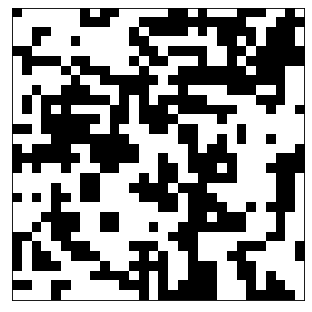

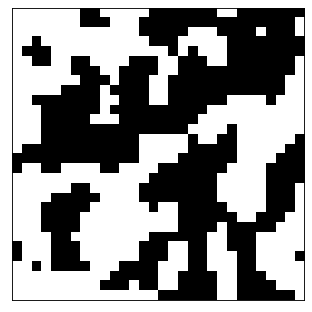

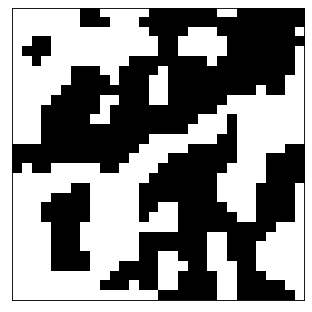

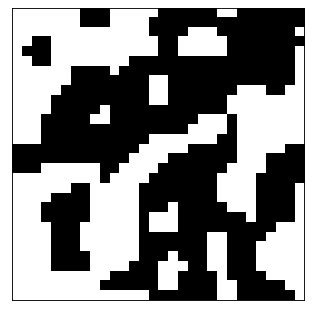

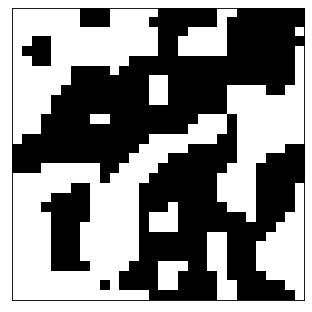

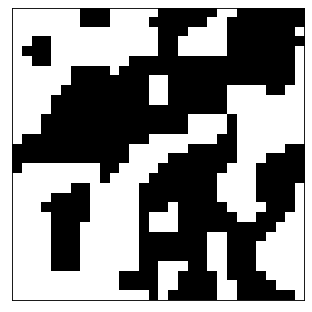

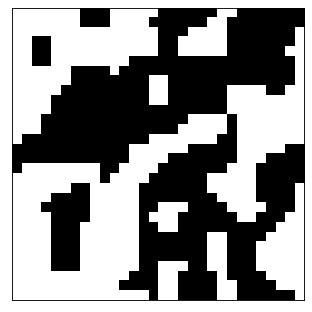

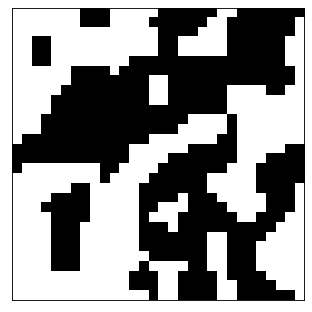

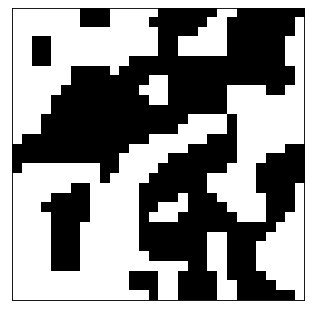

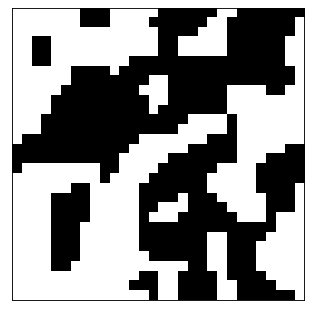

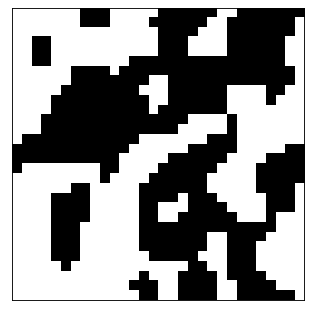

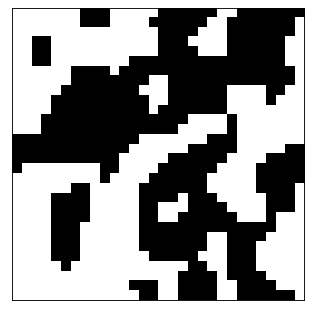

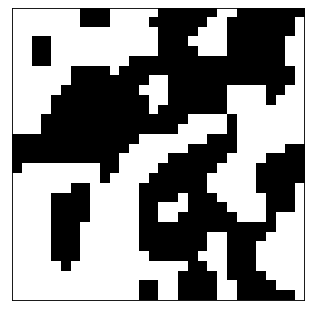

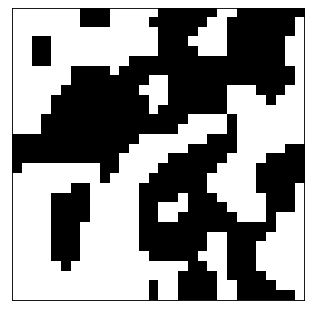

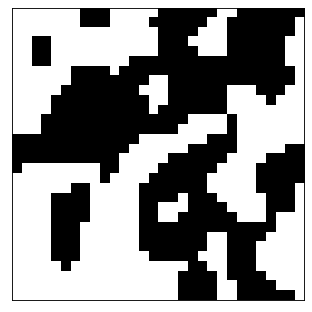

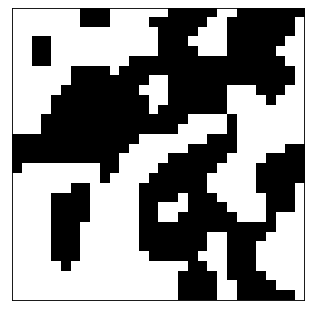

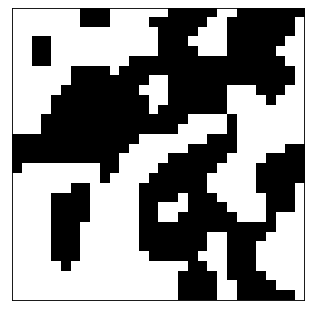

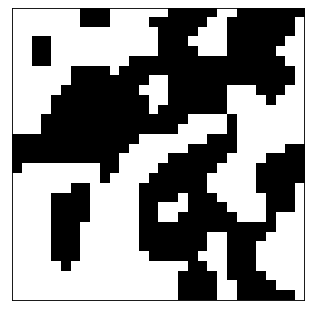

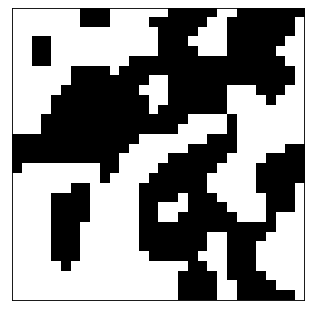

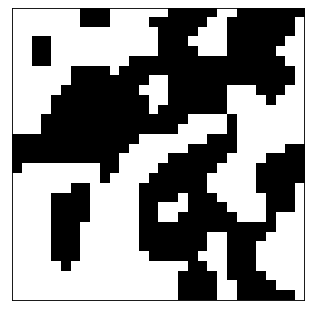

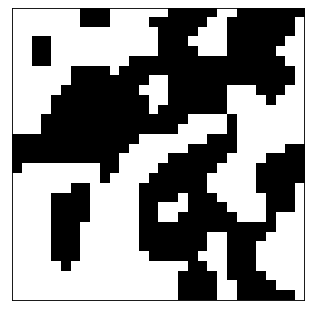

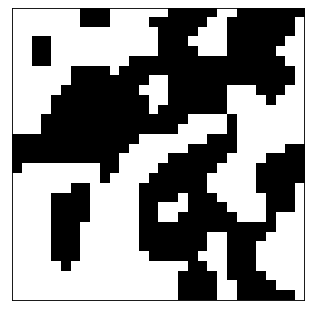

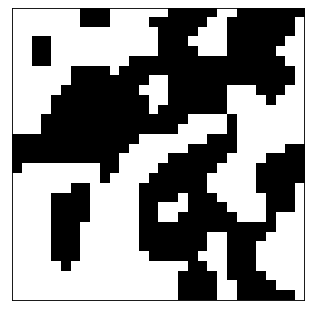

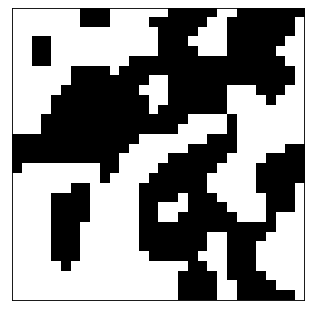

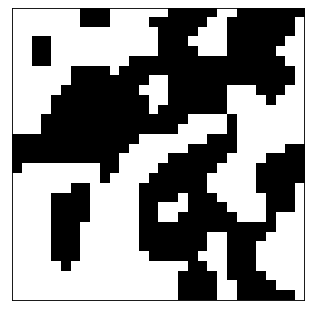

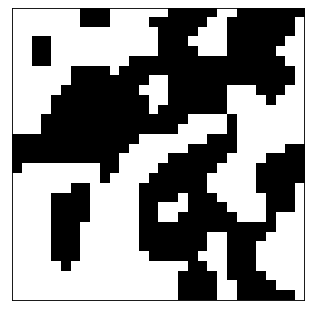

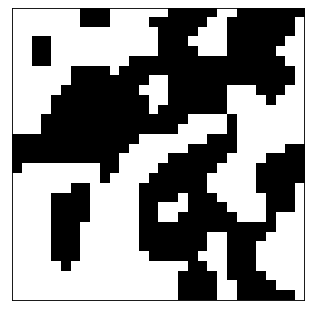

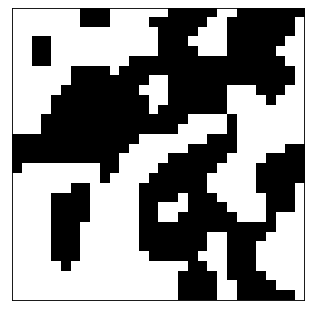

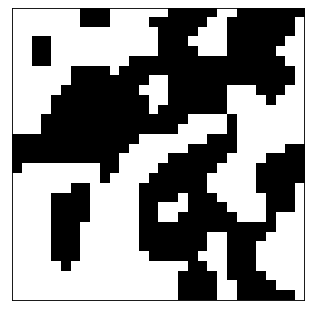

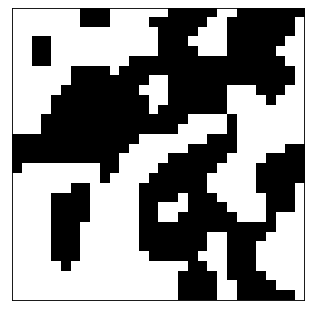

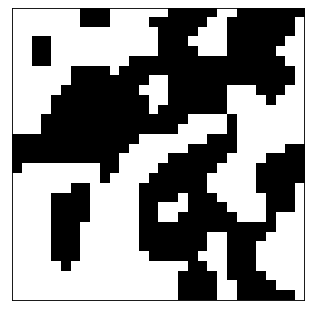

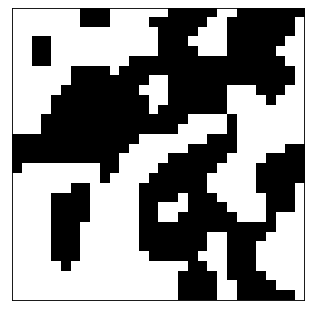

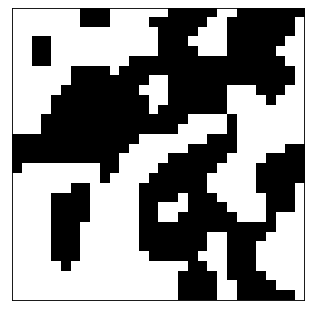

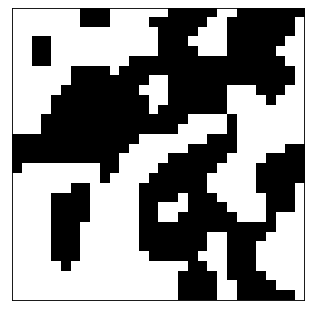

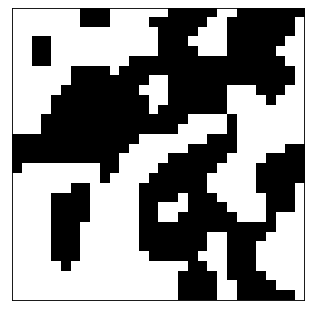

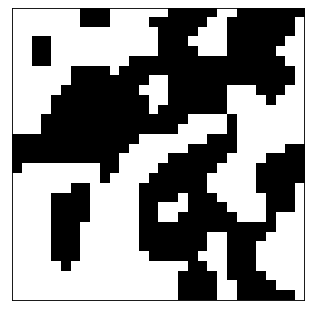

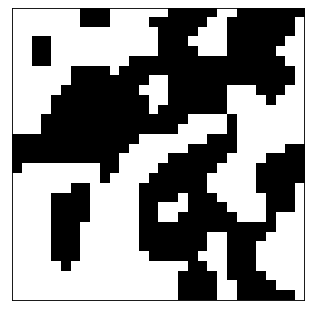

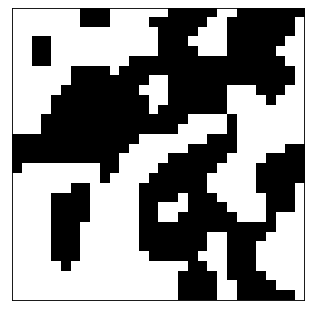

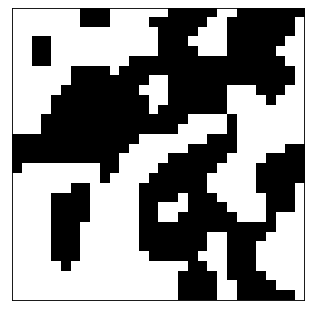

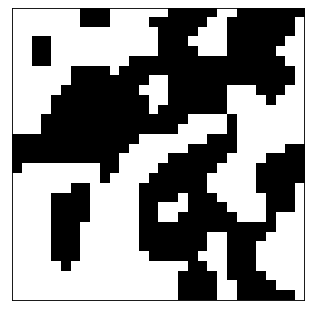

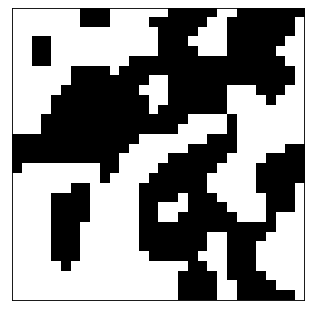

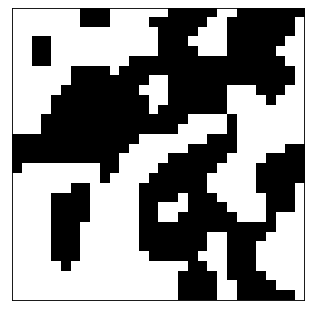

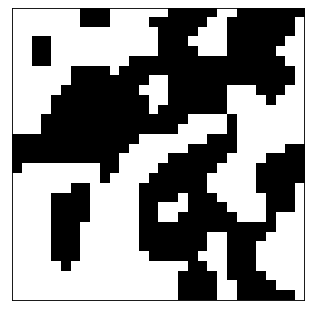

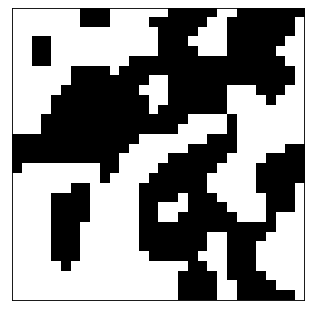

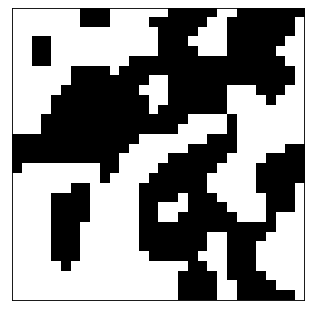

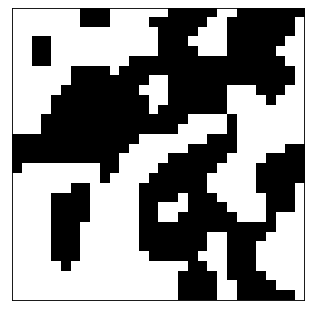

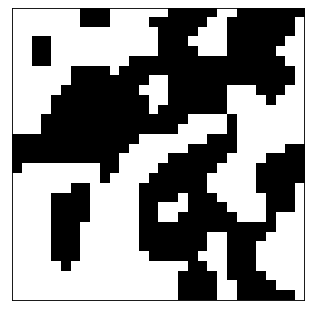

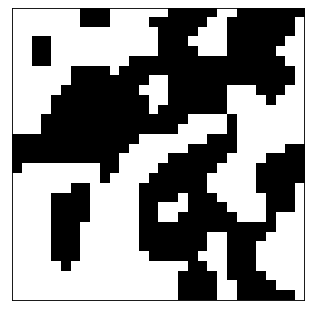

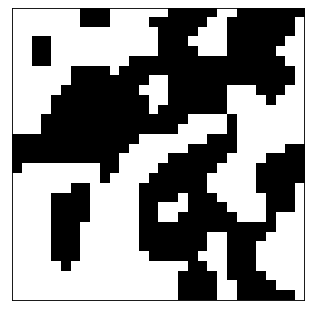

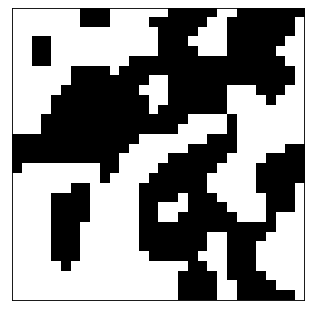

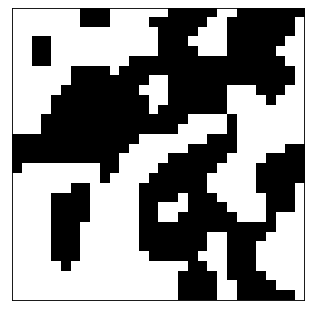

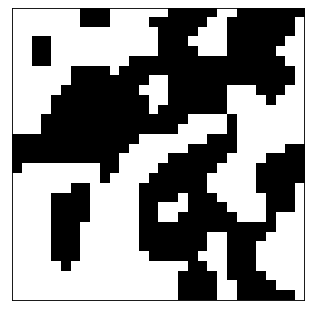

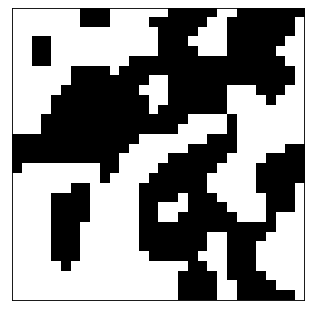

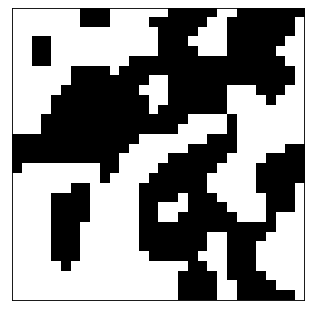

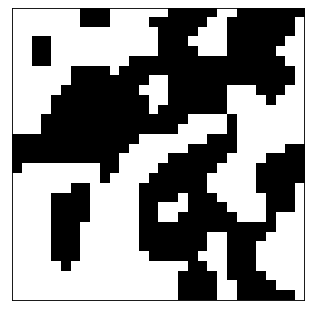

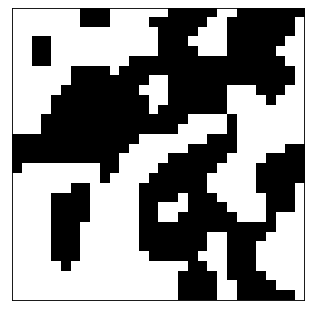

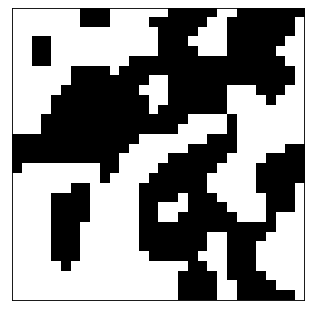

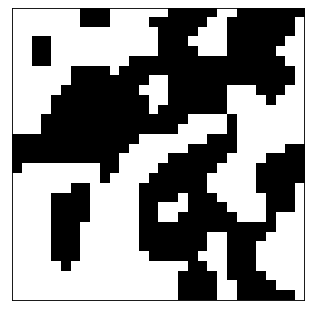

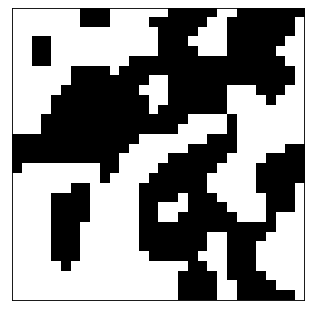

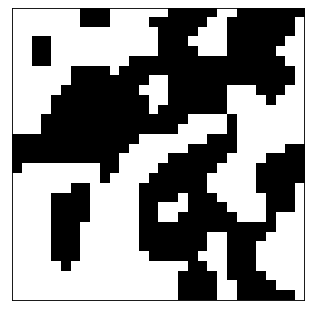

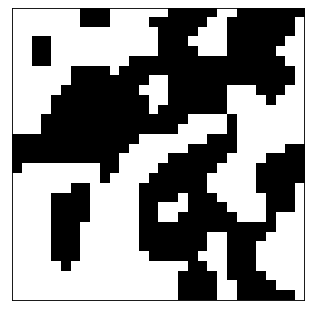

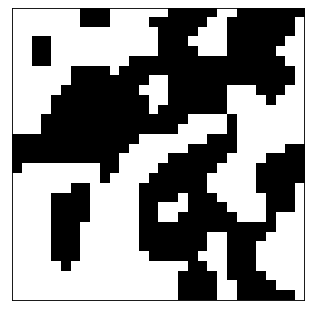

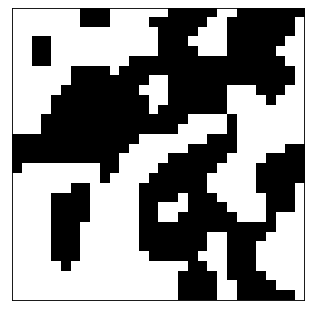

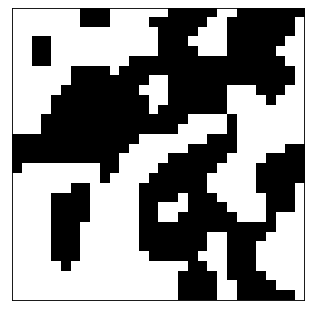

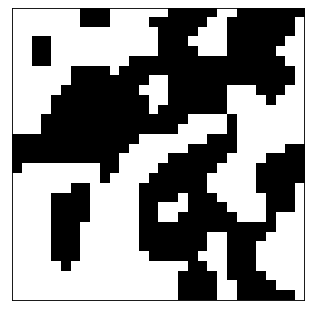

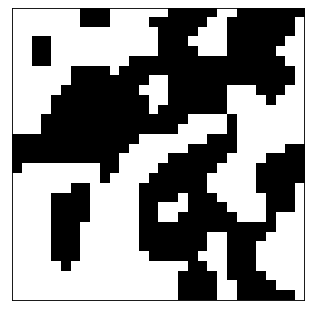

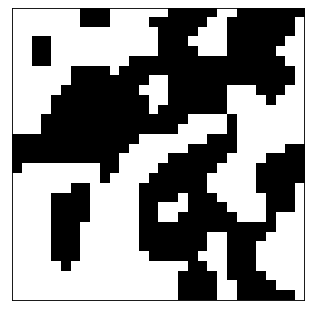

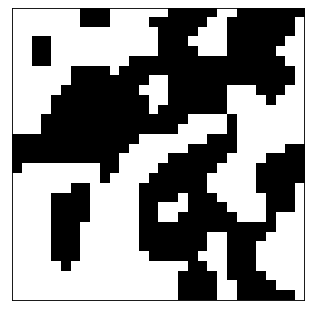

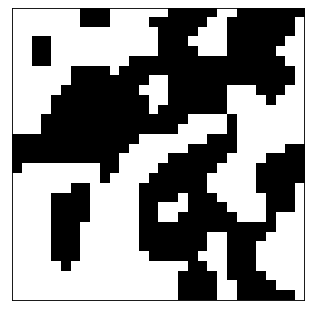

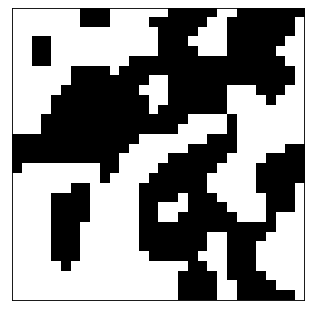

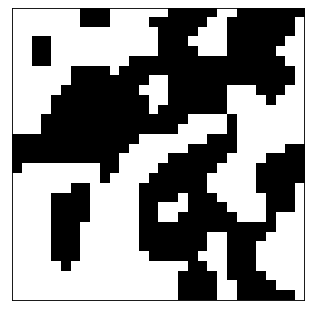

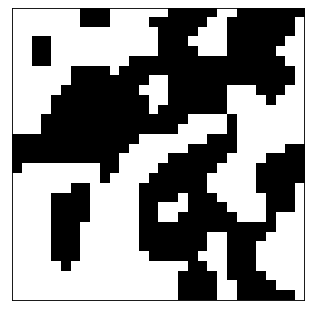

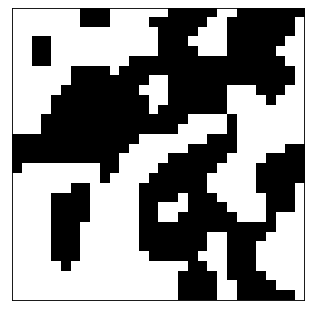

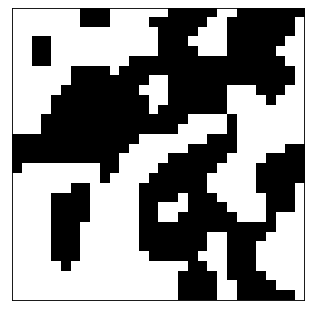

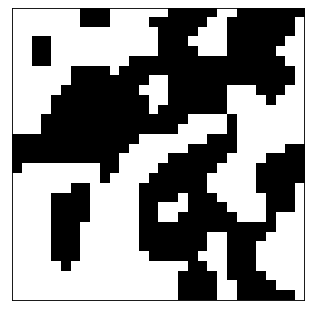

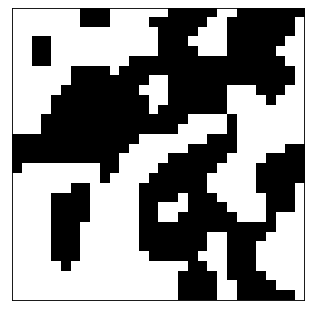

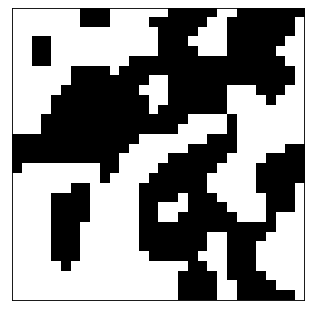

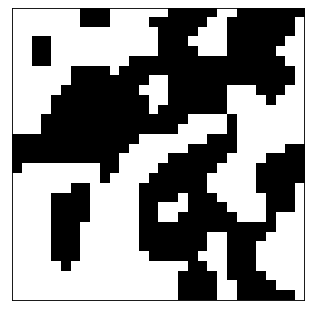

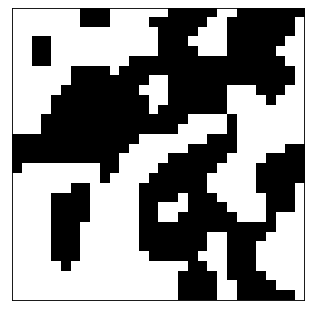

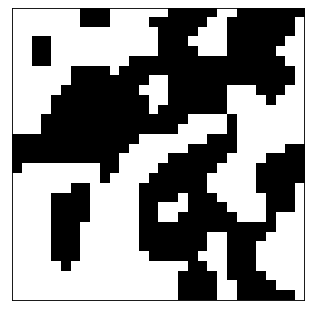

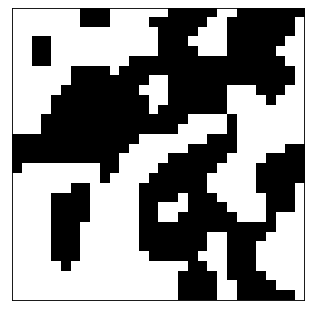

In [86]:
j = 0
save_plot_flag = 1
for j,conf in enumerate(flow_conf_list):
  fig, ax=plt.subplots(figsize=(4,4), dpi=80)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.imshow(conf.reshape(L,L), cmap='gray',vmin=0,vmax=1)
  plt.tight_layout()

  #resultsfolder=path0+'/results'+hyperparameters_txt+'T_i'+"{:.1f}".format(T_i)+'/' #folder where the results are saved
  resultsfolder='/home/s/Desktop/config_flow/'
  os.makedirs(resultsfolder, exist_ok=True)

  if save_plot_flag:
    figure_name=resultsfolder+'Iteration_'+"{:2d}".format(j)+'.pdf' # for disordered initial_state
    plt.savefig(figure_name, bbox_inches='tight')
  plt.show()


# NN-flow

data_T shape is:  (200, 100, 900)
NL_list: [12, 20, 24, 28, 36, 40, 44, 48, 52, 56, 60, 68, 72, 76, 80, 84, 88, 92, 96, 100, 104, 108, 112, 116, 120, 124, 132, 136, 140, 144, 148, 152, 156, 160, 164, 168]
T_cut_list: [2.5]
T_cut: 0  NL: 128


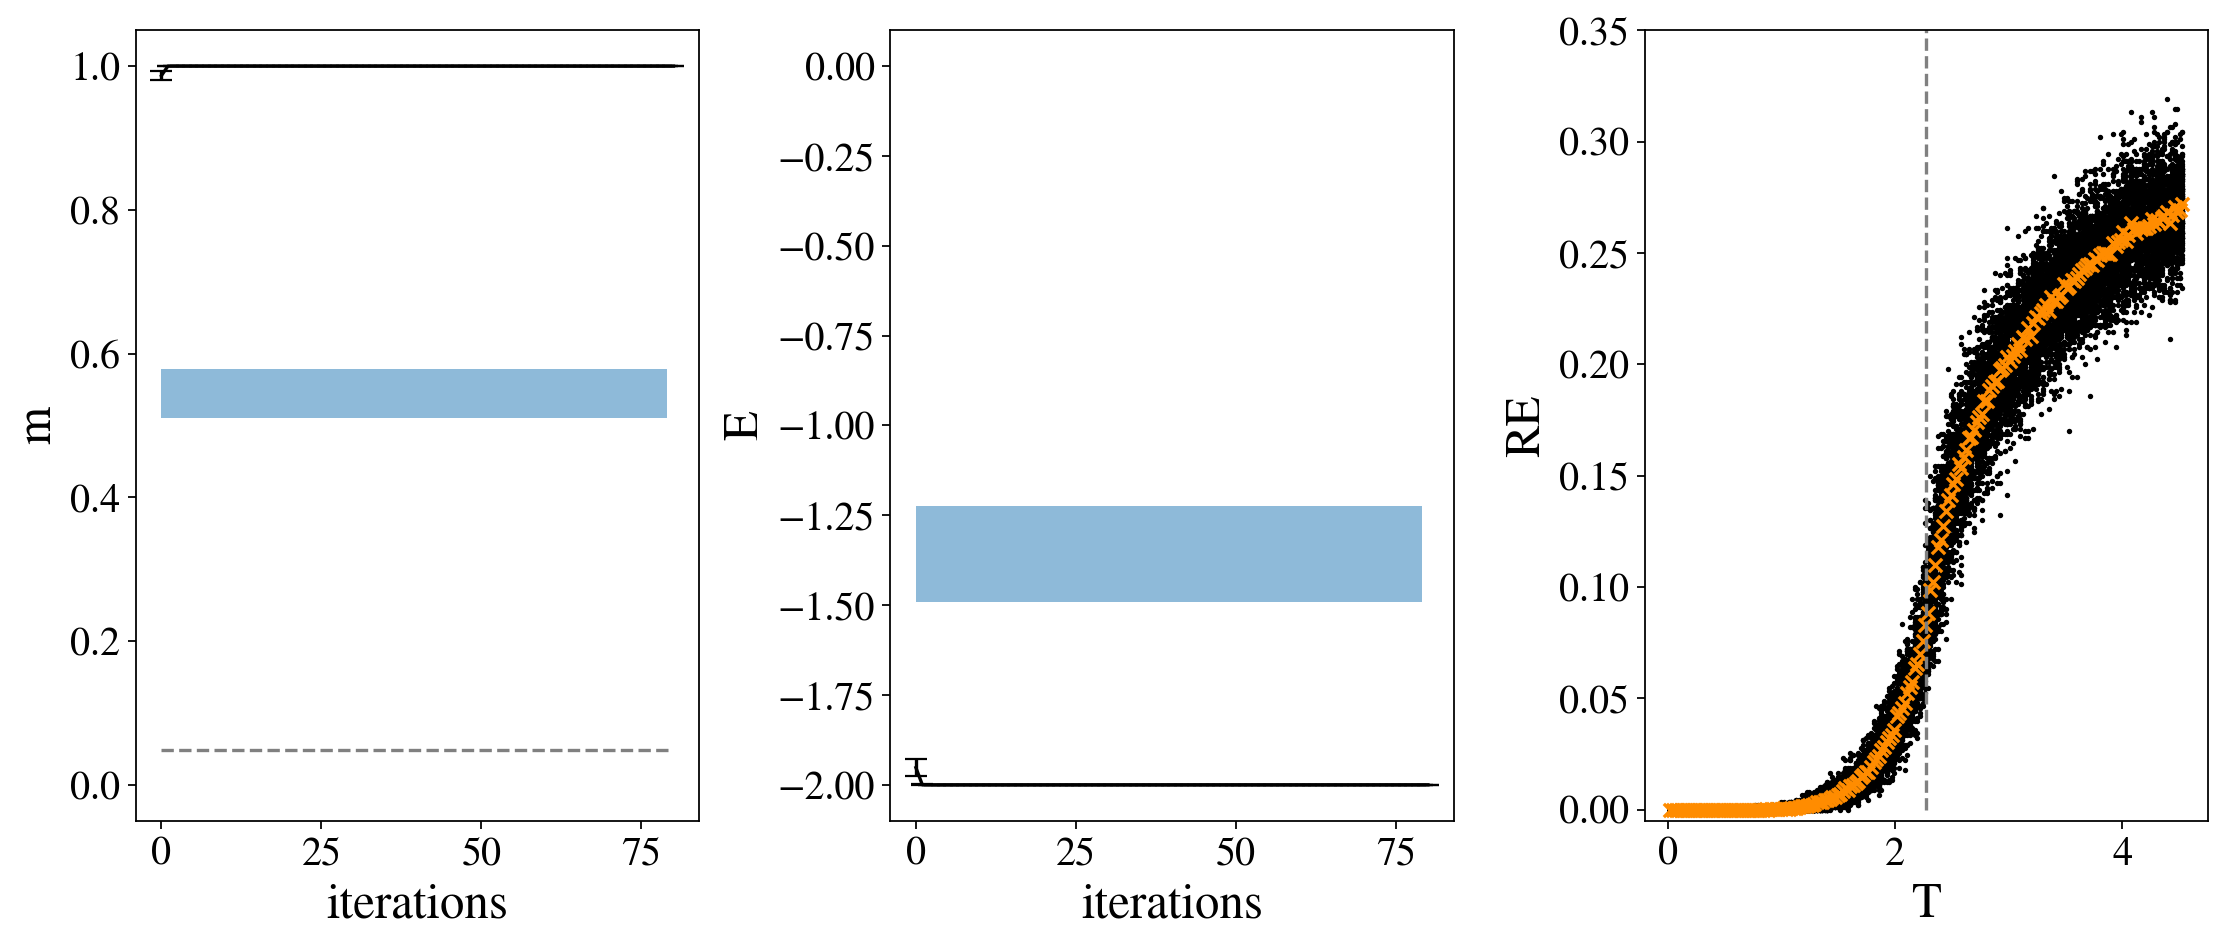

In [12]:
importlib.reload(r) # to be able to modify routines.py and use the modified version of the file

#Class
Class=d

#flow parameters
iterations=80
n_realizations=99
#n_snapshot=N_train #+ Class.n_Tc
n_snapshot=N_train + 134 # T_i = 1.49
T_i=Class.T[n_snapshot] #initial temperature
n_sigma=3

#flags
load_AE_flag=1 #loads trained autoencoder and computes everything
round_flag=1 #rounds configurations in each flow iteration
export_results_flag=1 #exports magnetization, energy and RE
load_results_flag=1 #loads magnetizations, energies and REs
save_plot_flag=1 # saves plot...
round_flag_RE=1 # rounds the reconstructed configurations before computing RE

#data grouped by temperatures, to compute the RE
data_T=r.data_by_temperatures(Class.data[N_train:],Class.n_T)

#T_cut_list=[2.0,2.5,3.0]
#T_cut_list+=[2.1,2.2,2.3,2.4,2.6,2.7,2.8,2.9]
#T_cut_list.sort()
T_cut_list=[2.5]

NL_list=[32+4*i for i in range(35)] # number of neurons in the latent space
NL_list.remove(32)
NL_list.remove(64)
NL_list.remove(128)
#NL_list=[2**n for n in range(1,11)] # number of neurons in the latent space
NL_list+=[12,20,24,28]
NL_list.sort()

print("NL_list:", NL_list)
print("T_cut_list:", T_cut_list)

NL_list=[128]
T_cut_list=[0]


for NL in NL_list:
  #first, path definitions for each NL
  hyperparameters_txt='/L'+str(L)+'/NL'+str(NL)+'/DO'+str(Dropoutflag)+'/rl2'+str(rl2)+\
  '/BS'+str(BS)+'/epochs'+str(n_epochs)+'/lr'+str(lr)+'/'
  resultsfolder=path0+'/results'+hyperparameters_txt+'T_i'+"{:.1f}".format(T_i)+'/' #folder where the results are saved
  os.makedirs(resultsfolder, exist_ok=True)
  modelfolder=path0+'/models'+hyperparameters_txt #folder where the models will be saved
  ##
  for T_cut in T_cut_list:
    print('T_cut:',T_cut,' NL:',NL)
    if load_AE_flag:
      name_encoder='trained_encoder_T'+"{:.1f}".format(T_cut)+'.h5'
      name_decoder='trained_decoder_T'+"{:.1f}".format(T_cut)+'.h5'
      autoencoder=AEFullyConnected(NL,L,rl2)
      autoencoder.encoder = load_model(modelfolder+name_encoder, compile=False)
      autoencoder.decoder = load_model(modelfolder+name_decoder, compile=False)
      print('computing flow')
      final_configurations,mag_lists,E_lists=r.flows(n_snapshot,n_realizations,iterations,Class.n_T,autoencoder,Class.data,Class.T,L,round_flag)
      print('computing R.E.')
      T_plot,RE_T=r.get_RE_vs_T(data_T,autoencoder,Class.n_T,Class.T[:Class.n_T],round_flag_RE)
      ##
      if (export_results_flag):
        np.save(resultsfolder+'mag_flow_T'+"{:.1f}".format(T_cut),np.array(mag_lists))
        np.save(resultsfolder+'E_flow_T'+"{:.1f}".format(T_cut),np.array(E_lists))
        np.save(resultsfolder+'RE_T'+"{:.1f}".format(T_cut),np.array(RE_T))
    ##
    if load_results_flag:
      mag_lists=np.load(resultsfolder+'mag_flow_T'+"{:.1f}".format(T_cut)+'.npy')
      E_lists=np.load(resultsfolder+'E_flow_T'+"{:.1f}".format(T_cut)+'.npy')
      RE_T=np.load(resultsfolder+'RE_T'+"{:.1f}".format(T_cut)+'.npy')
      T_plot=[]
      n_data=np.shape(RE_T)[1]
      for i in range(Class.n_T):
        T_plot.append([Class.T[i]for j in range(n_data)])
    ###########Plot magnetization flow
    plt.figure(figsize=(14, 6), dpi=160)
    plt.subplot(1, 3, 1)
    #for i in range(len(mag_lists)):
    #  plt.plot(np.absolute(mag_lists[i]))
    plt.xlabel('iterations',size=22)
    plt.ylabel('m',size=22)
    plt.ylim([-.05,1.05])
    plt.fill_between(range(iterations), Class.mTc[0]-n_sigma*Class.mTc[1], Class.mTc[0]+n_sigma*Class.mTc[1],alpha=.5)
    plt.errorbar(range(iterations+1),np.mean(np.absolute(mag_lists),axis=0),yerr=np.std(np.absolute(mag_lists),axis=0),capsize=5,color='black')
    plt.hlines(0.04808888888888888,0,iterations,linestyle='dashed',color='grey') # magnetization at T=4.53 and L=30
    ############Plot Energy flow
    plt.subplot(1, 3, 2)
    #for i in range(len(mag_lists)):
    #  plt.plot(E_lists[i])
    plt.xlabel('iterations',size=22)
    plt.ylabel('E',size=22)
    plt.fill_between(range(iterations), Class.ETc[0]-n_sigma*Class.ETc[1], Class.ETc[0]+n_sigma*Class.ETc[1],alpha=.5)
    plt.ylim([-2.1,0.1])
    #plt.plot(np.mean(E_lists,axis=0),linestyle='dashed',color='black')
    plt.errorbar(range(iterations+1),np.mean(E_lists,axis=0),yerr=np.std(E_lists,axis=0),capsize=5,color='black')
    ###########RE_vs_T
    plt.subplot(1, 3, 3)
    mean_RE_T=np.mean(RE_T,axis=1)
    plt.scatter(T_plot,RE_T,s=2,c='black')
    plt.scatter(Class.T[:Class.n_T],mean_RE_T,c='darkorange',marker='x')
    plt.xlabel('T',size=22)
    plt.ylabel('RE',size=22)
    plt.ylim([-0.005,0.35])
    plt.vlines(Tc,0,0.53,linestyles='dashed',color='grey')
    if (T_cut>0):
      plt.vlines(T_cut,0,0.53,color='black')
    plt.tight_layout()
    ##
    if save_plot_flag:
      figure_name=resultsfolder+'h_T_cut_'+"{:.1f}".format(T_cut)+'.png' # for disordered initial_state
      plt.savefig(figure_name, bbox_inches='tight')
    plt.show()

# Flows to show

NL_list: [128]
T_cut_list: [0]
T_i_list: [1.5, 4.5]
T_i: 1.5  T_cut: 0  NL: 128
T_i: 4.5  T_cut: 0  NL: 128


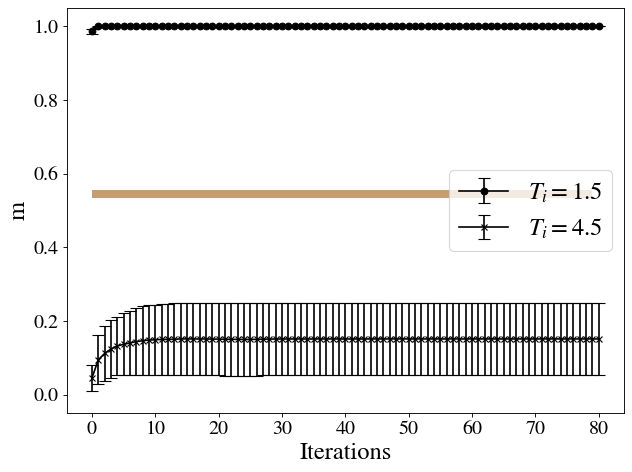

In [5]:
importlib.reload(r) # to be able to modify routines.py and use the modified version of the file

#Class
Class=d

#flow parameters
iterations=80
n_realizations=99
#n_snapshot=N_train #+ Class.n_Tc
n_snapshot=N_train + 134 # T_i = 1.49
T_i=Class.T[n_snapshot] #initial temperature
n_sigma=1

#flags
load_results_flag=1 #loads magnetizations, energies and REs
save_plot_flag=1 # saves plot...
plot_mag_flag=1

if plot_mag_flag:
  x='m'
else:
  x='E'


T_cut_list=[0]
T_i_list=[1.5,4.5]

print("NL_list:", NL_list)
print("T_cut_list:", T_cut_list)
print("T_i_list:", T_i_list)

plt.figure(figsize=(8, 6), dpi=80)
j=0
for T_i in T_i_list:
  for NL in NL_list:
    #first, path definitions for each NL
    hyperparameters_txt='/L'+str(L)+'/NL'+str(NL)+'/DO'+str(Dropoutflag)+'/rl2'+str(rl2)+\
    '/BS'+str(BS)+'/epochs'+str(n_epochs)+'/lr'+str(lr)+'/'
    resultsfolder=path0+'/results'+hyperparameters_txt+'T_i'+"{:.1f}".format(T_i)+'/' #folder where the results are saved
    os.makedirs(resultsfolder, exist_ok=True)
    modelfolder=path0+'/models'+hyperparameters_txt #folder where the models will be saved
    ##
    for T_cut in T_cut_list:
      print('T_i:',T_i,' T_cut:',T_cut,' NL:',NL)
      if load_results_flag:
        mag_lists=np.load(resultsfolder+'mag_flow_T'+"{:.1f}".format(T_cut)+'.npy')
        E_lists=np.load(resultsfolder+'E_flow_T'+"{:.1f}".format(T_cut)+'.npy')
        RE_T=np.load(resultsfolder+'RE_T'+"{:.1f}".format(T_cut)+'.npy')
        T_plot=[]
        n_data=np.shape(RE_T)[1]
        for i in range(Class.n_T):
          T_plot.append([Class.T[i]for j in range(n_data)])
      ###########Plot magnetization flow
      if plot_mag_flag:
        #for i in range(len(mag_lists)):
        #  plt.plot(np.absolute(mag_lists[i]))
        plt.xlabel('Iterations',size=22)
        plt.ylabel('m',size=22)
        plt.ylim([-.05,1.05])
        plt.fill_between(range(iterations), Class.mTc[0]-n_sigma*Class.mTc[1], Class.mTc[0]+n_sigma*Class.mTc[1],alpha=.5)
        plt.errorbar(range(iterations+1),np.mean(np.absolute(mag_lists),axis=0),
                     yerr=np.std(np.absolute(mag_lists),axis=0),capsize=5,marker=markerslist2[j],color='black',label=r'$T_i=$'+str(T_i))
        j+=1
        #if (inesflag):
        #  plt.hlines(0.04808888888888888,0,iterations,linestyle='dashed',color='grey') # magnetization at T=4.53 and L=30
      else:
        ############Plot Energy flow
        #for i in range(len(mag_lists)):
        #  plt.plot(E_lists[i])
        plt.xlabel('Iterations',size=22)
        plt.ylabel('E',size=22)
        plt.fill_between(range(iterations), Class.ETc[0]-n_sigma*Class.ETc[1], Class.ETc[0]+n_sigma*Class.ETc[1],alpha=.5)
        plt.ylim([-2.1,0.1])
        #plt.plot(np.mean(E_lists,axis=0),linestyle='dashed',color='black')
        plt.errorbar(range(iterations+1),np.mean(E_lists,axis=0),yerr=np.std(E_lists,axis=0),
                     capsize=5,marker=markerslist2[j],color='black',label=r'$T_i=$'+str(T_i))
        j+=1
      plt.legend(prop={'size': 22})
      plt.tight_layout()
      ##
      if save_plot_flag:
        figure_name=resultsfolder+x+'flow_T'+"{:.1f}".format(T_cut)+'.pdf' # for disordered initial_state
        plt.savefig(figure_name, bbox_inches='tight')
plt.show()

# E* and m*

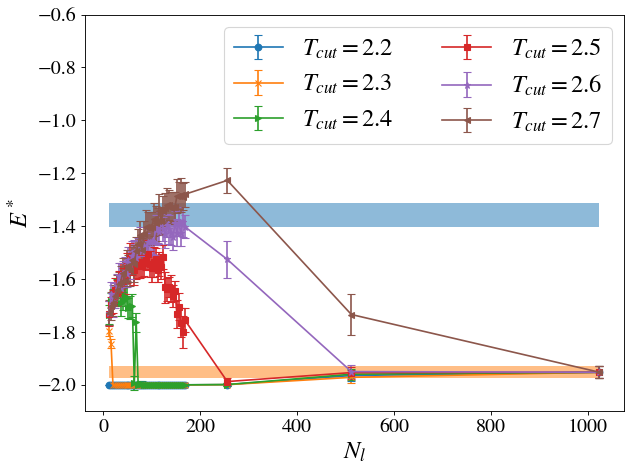

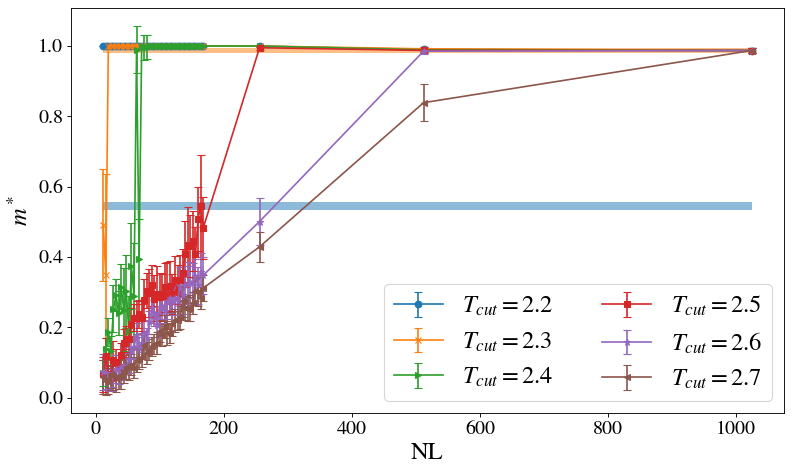

In [15]:
Class=d
#NL_list=[32+4*i for i in range(35)] # number of neurons in the latent space
#NL_list.append(256) ; NL_list.append(512)
NL_list=[32+4*i for i in range(35)] # number of neurons in the latent space
NL_list.remove(32)
NL_list.remove(64)
NL_list.remove(128)
NL_list+=[2**n for n in range(4,11)] # number of neurons in the latent space
NL_list+=[12,20,24,28]
NL_list.sort()
T_cut_list=[2.2,2.3,2.4,2.5,2.6,2.7]

T_i=1.5
#NL_list=[2**n for n in range(1,11)] # number of neurons in the latent space
#T_cut_list=[2.,2.1,2.2,2.3,2.5,2.6,2.7,2.8,2.9]

E_star_lists=[]
E_star_sigma_lists=[]
m_star_lists=[]
m_star_sigma_lists=[]
for T_cut in T_cut_list:
  E_star_list=[]
  E_star_sigma_list=[]
  m_star_list=[]
  m_star_sigma_list=[]
  for NL in NL_list:    
    hyperparameters_txt='/L'+str(L)+'/NL'+str(NL)+'/DO'+str(Dropoutflag)+'/rl2'+str(rl2)+\
    '/BS'+str(BS)+'/epochs'+str(n_epochs)+'/lr'+str(lr)+'/'
    resultsfolder=path0+'/results'+hyperparameters_txt+'T_i'+"{:.1f}".format(T_i)+'/'
    E_path=resultsfolder+'E_flow_T'+"{:.1f}".format(T_cut)+'.npy'
    m_path=resultsfolder+'mag_flow_T'+"{:.1f}".format(T_cut)+'.npy'
    E_star,E_star_sigma,E_0,E_0_std=r.get_x_star(E_path,0)
    m_star,m_star_sigma,m_0,m_0_std=r.get_x_star(m_path,1)
    E_star_list.append(E_star)
    E_star_sigma_list.append(E_star_sigma)
    m_star_list.append(m_star)
    m_star_sigma_list.append(m_star_sigma)
  E_star_lists.append(E_star_list)
  E_star_sigma_lists.append(E_star_sigma_list)
  m_star_lists.append(m_star_list)
  m_star_sigma_lists.append(m_star_sigma_list)

n_sigma=1
###E* plot
fig, ax = plt.subplots(figsize=(8, 6), dpi=80)
for i in range(len(T_cut_list)):
  plt.errorbar(NL_list,E_star_lists[i],yerr=E_star_sigma_lists[i],fmt=markerslist[i],capsize=4,label=r'$T_{cut}=$'+str(T_cut_list[i]))
plt.fill_between(NL_list, Class.ETc[0]-n_sigma*Class.ETc[1], Class.ETc[0]+n_sigma*Class.ETc[1],alpha=.5)
plt.fill_between(NL_list, E_0-E_0_std, E_0+E_0_std,alpha=.5)

plt.xlabel(r'$N_l$',size=22)
plt.ylabel(r'$E^*$',size=22)
plt.ylim([-2.1,-0.6])
ax.legend(prop={'size': 22},ncol=2)
plt.show()

###M* plot
fig, ax = plt.subplots(figsize=(10, 6), dpi=80)
for i in range(len(T_cut_list)):
  plt.errorbar(NL_list,m_star_lists[i],yerr=m_star_sigma_lists[i],fmt=markerslist[i],capsize=4,label=r'$T_{cut}=$'+str(T_cut_list[i]))
plt.fill_between(NL_list, Class.mTc[0]-n_sigma*Class.mTc[1], Class.mTc[0]+n_sigma*Class.mTc[1],alpha=.5)
plt.fill_between(NL_list, m_0-m_0_std, m_0+m_0_std,alpha=.5)

plt.xlabel('NL',size=22)
plt.ylabel(r'$m^*$',size=22)
#plt.ylim([-0.01,1.01])
#plt.xlim([0,256])
ax.legend(prop={'size': 22},ncol=2)
plt.show()

# RE VS T, Nl 128

NL_list: [128]
T_cut_list: [2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8]


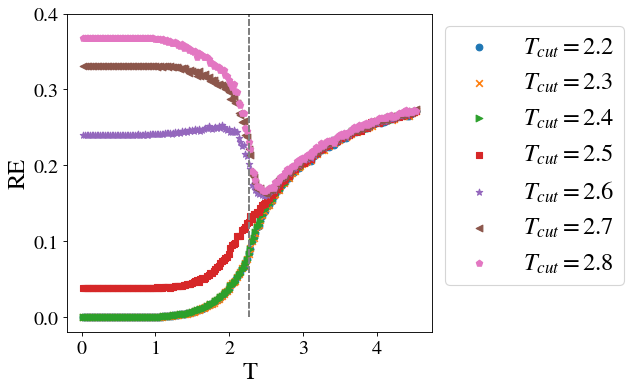

In [23]:
importlib.reload(r) # to be able to modify routines.py and use the modified version of the file

#Class
Class=d

#flow parameters
iterations=80
n_realizations=99
#n_snapshot=N_train #+ Class.n_Tc
n_snapshot=N_train #+ 134 # T_i = 1.49
T_i=Class.T[n_snapshot] #initial temperature
n_sigma=3


T_cut_list=[2.2,2.3,2.4,2.5,2.6,2.7,2.8]
NL_list=[128]


print("NL_list:", NL_list)
print("T_cut_list:", T_cut_list)
fig, ax = plt.subplots(figsize=(8, 5), dpi=80)
defaultcolors=plt.rcParams['axes.prop_cycle'].by_key()['color']

j=0
for NL in NL_list:
  #first, path definitions for each NL
  hyperparameters_txt='/L'+str(L)+'/NL'+str(NL)+'/DO'+str(Dropoutflag)+'/rl2'+str(rl2)+\
  '/BS'+str(BS)+'/epochs'+str(n_epochs)+'/lr'+str(lr)+'/'
  resultsfolder=path0+'/results'+hyperparameters_txt+'T_i'+"{:.1f}".format(T_i)+'/' #folder where the results are saved
  os.makedirs(resultsfolder, exist_ok=True)
  modelfolder=path0+'/models'+hyperparameters_txt #folder where the models will be saved
  ##
  for T_cut in T_cut_list:
    RE_T=np.load(resultsfolder+'RE_T'+"{:.1f}".format(T_cut)+'.npy')
    T_plot=[]
    n_data=np.shape(RE_T)[1]
    for i in range(Class.n_T):
      T_plot.append([Class.T[i]for j in range(n_data)])
   ###########RE_vs_T
    mean_RE_T=np.mean(RE_T,axis=1)
    plt.scatter(Class.T[:Class.n_T],mean_RE_T,marker=markerslist2[j],label=r'$T_{cut}=$'+str(T_cut))
    plt.xlabel('T',size=22)
    plt.ylabel('RE',size=22)
    plt.ylim([-0.005,0.53])
    plt.vlines(Tc,0,0.53,linestyles='dashed',color='grey')
    #if (T_cut>0):
      #plt.vlines(T_cut,0,0.53,color=defaultcolors[j])
    j+=1
plt.tight_layout()
#ax.legend(fontsize=22,ncol=1)
ax.legend(fontsize=22, bbox_to_anchor=(1.0, 1.0))
plt.ylim([-0.02,.4])
plt.show()


# RE*

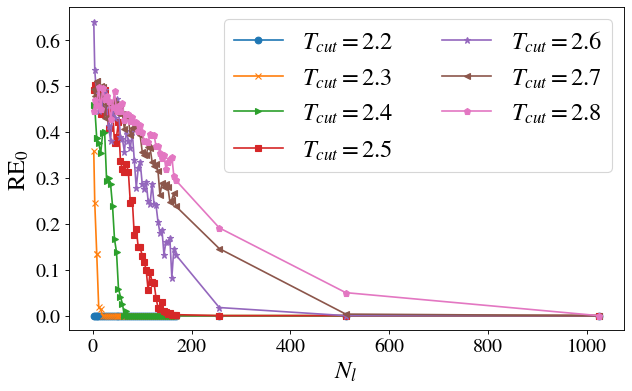

In [5]:
#NL_list=[32+4*i for i in range(35)] # number of neurons in the latent space
#NL_list.append(256) ; NL_list.append(512)

NL_list=[32+4*i for i in range(35)] # number of neurons in the latent space
NL_list.remove(32)
NL_list.remove(64)
NL_list.remove(128)
NL_list+=[2**n for n in range(1,11)] # number of neurons in the latent space
NL_list+=[8,12,20,24,28]
NL_list.sort()
T_cut_list=[2.2,2.3,2.4,2.5,2.6,2.7,2.8]
RE_minima_list=[]
T_i=4.5
for T_cut in T_cut_list:
  RE_minima=[]
  for NL in NL_list:    
    hyperparameters_txt='/L'+str(L)+'/NL'+str(NL)+'/DO'+str(Dropoutflag)+'/rl2'+str(rl2)+\
    '/BS'+str(BS)+'/epochs'+str(n_epochs)+'/lr'+str(lr)+'/'
    resultsfolder=path0+'/results'+hyperparameters_txt+'T_i'+"{:.1f}".format(T_i)+'/'
    RE_T=np.load(resultsfolder+'RE_T'+"{:.1f}".format(T_cut)+'.npy')
    #RE_minima.append(np.amin(np.mean(RE_T,axis=1)))
    RE_minima.append(np.mean(RE_T,axis=1)[-1])
  RE_minima_list.append(RE_minima)

fig, ax = plt.subplots(figsize=(8, 5), dpi=80)
for i in range(len(T_cut_list)):
  plt.plot(NL_list,RE_minima_list[i],marker=markerslist2[i],label=r'$T_{cut}=$'+str(T_cut_list[i]))
plt.xlabel(r'$N_l$',size=22)
plt.ylabel("RE"+r'$_0$',size=22)
#plt.ylim([-2.1,0.1])
ax.legend(fontsize=22,ncol=2)#prop={'size': 22})
plt.show()

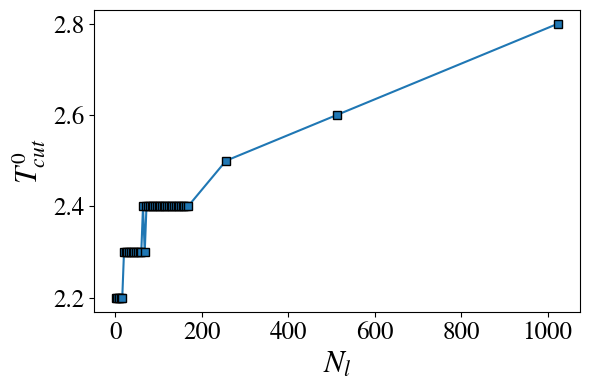

In [153]:
transition_indices = []
T_cut_list.reverse() 
reversed_T_cut_list = T_cut_list
T_cut_list.reverse()

for i,NL in enumerate(NL_list):
  for j,T_cut in enumerate(T_cut_list):
    # reverse order
    if(RE_minima_list[-j-1][i]==0):
      index=j
      break
  transition_indices.append(index)

T_cut_0_list = [T_cut_list[index] for index in transition_indices]



fig, ax = plt.subplots(figsize=(6,4), dpi=100)
plt.plot(NL_list,T_cut_0_list,'-s',markeredgecolor='black')
plt.xlabel(r"$N_l$",size=22)
plt.ylabel(r"$T_{cut}^0$",size=22)
plt.show()

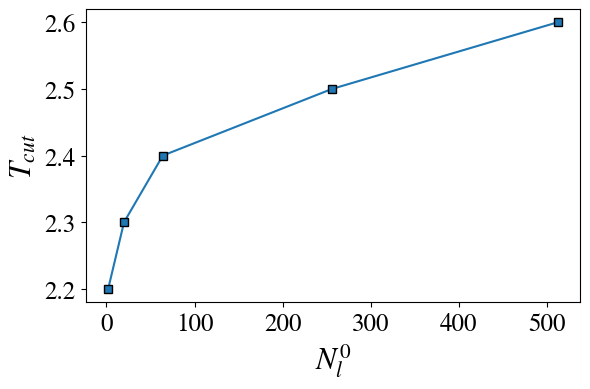

In [83]:
transition_indices = []

# this loops take the indices where RE0=0 and put them in the list <transition_indices>
for RE0_list in RE_minima_list:
  for j,element in enumerate(RE0_list):
    if (element == 0):
      index = j
      break
  transition_indices.append(index)

# the list with the values of NL where RE0=0, using list comprehension
NL0_list = [NL_list[index] for index in transition_indices]


fig, ax = plt.subplots(figsize=(6,4), dpi=100)
plt.plot(NL0_list[:-2],T_cut_list[:-2],'-s',markeredgecolor='black')
plt.xlabel(r"$N_l^0$",size=22)
plt.ylabel(r"$T_{cut}$",size=22)
plt.show()

# Reconstructed m and E

In [17]:
Class=d

#data grouped by temperatures, to compute physical quantities
data_T=r.data_by_temperatures(Class.data[N_train:],Class.n_T)
n_data=np.shape(data_T)[1]

mag_T=[]
E_T=[]
for i in range(Class.n_T):
  mag_T.append([abs(r.mag(data_T[i][j],L)) for j in range(n_data)])
  E_T.append([r.Ener(data_T[i][j],L) for j in range(n_data)])

data_T shape is:  (200, 100, 900)


T_cut:1.5
NL:2


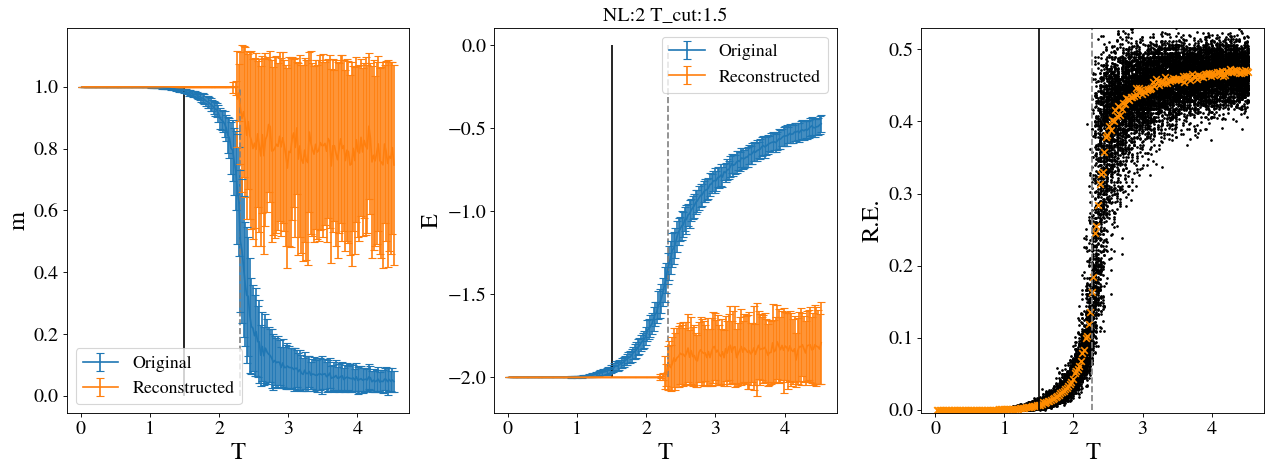

NL:4


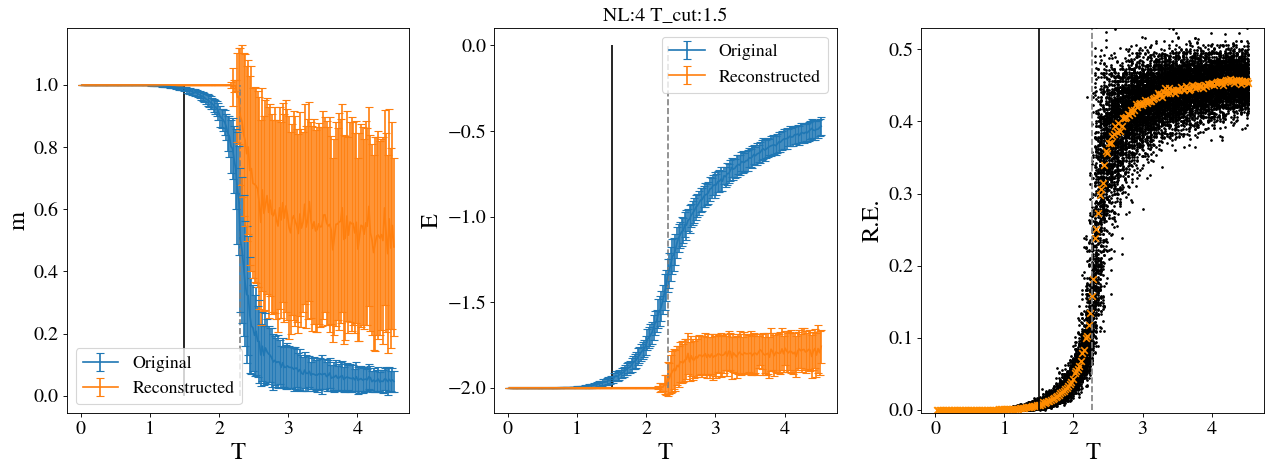

NL:8


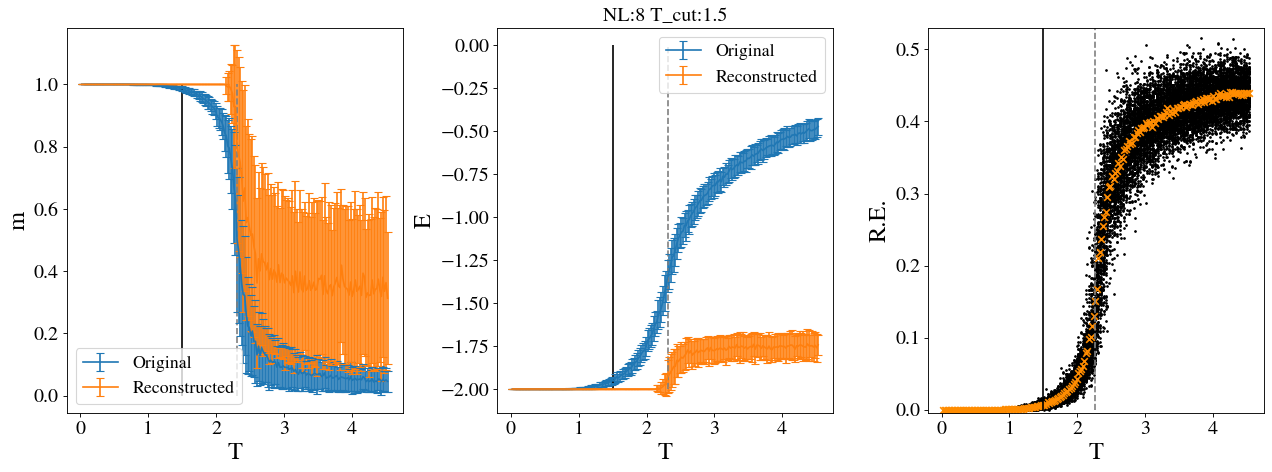

NL:16


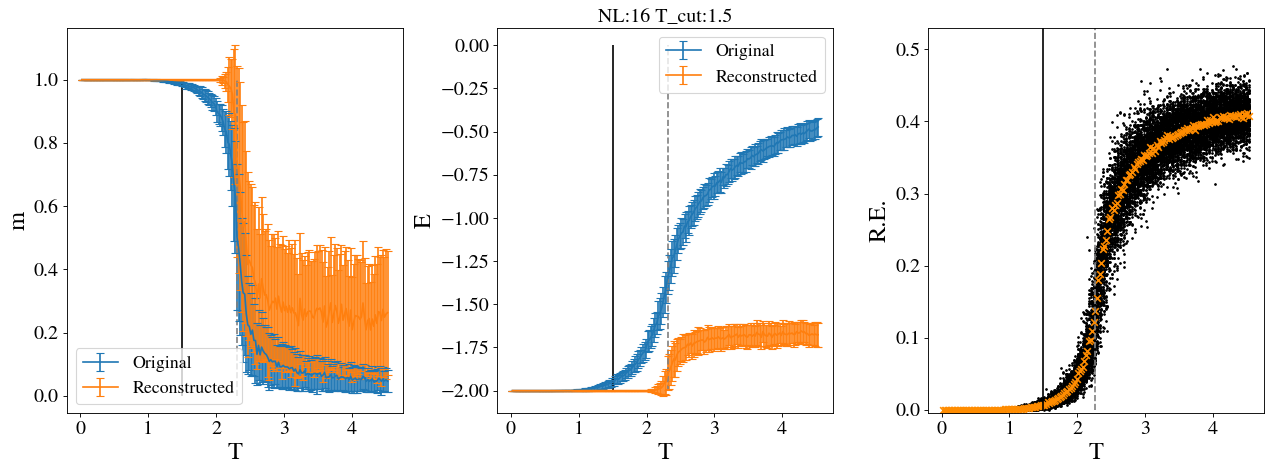

NL:32


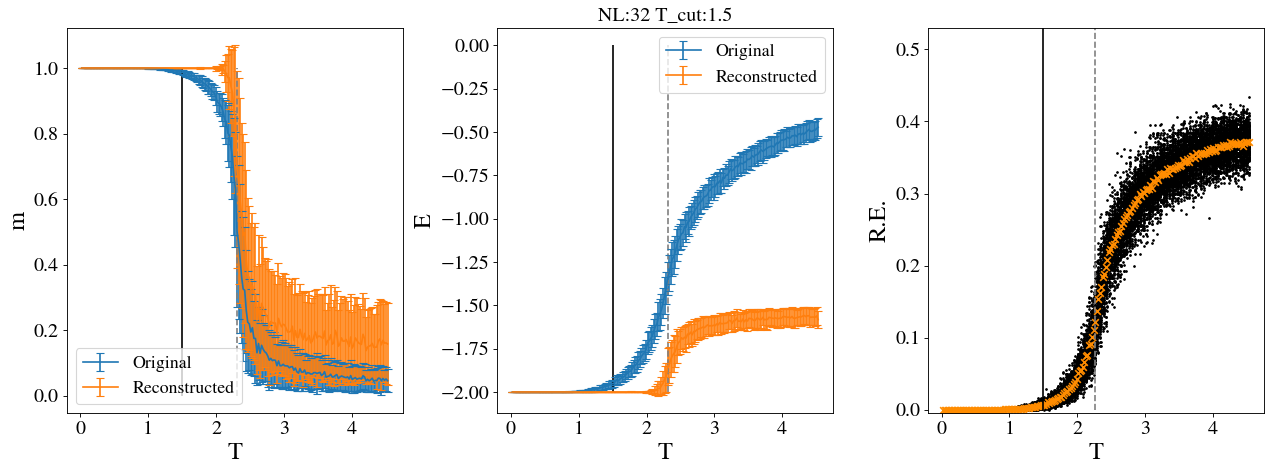

NL:64


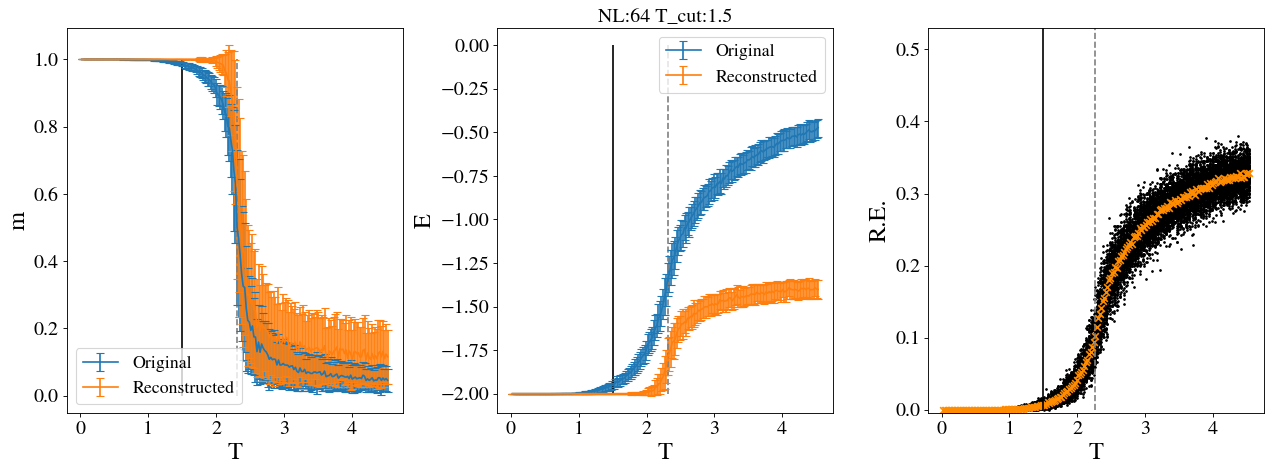

NL:128


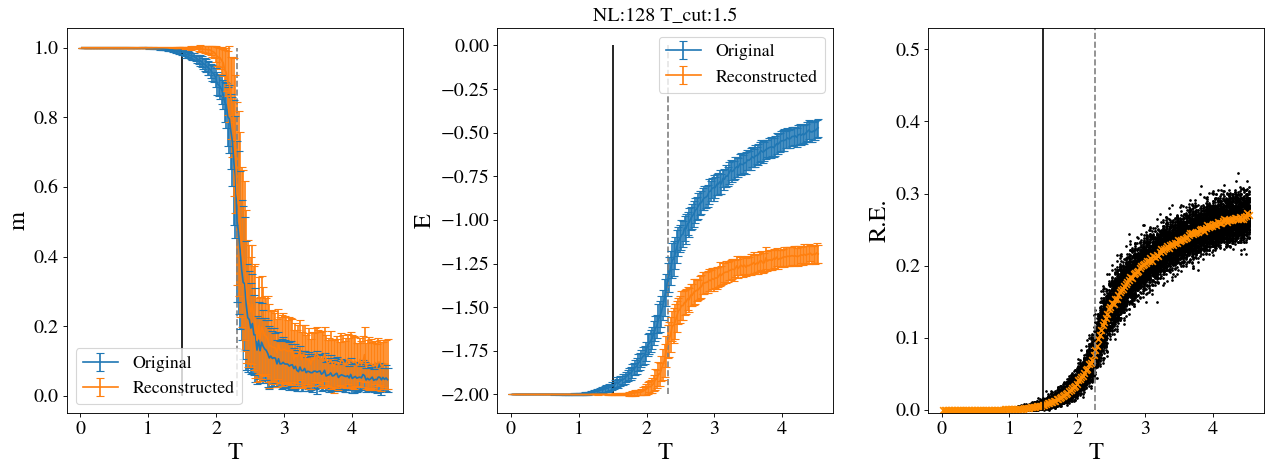

NL:256


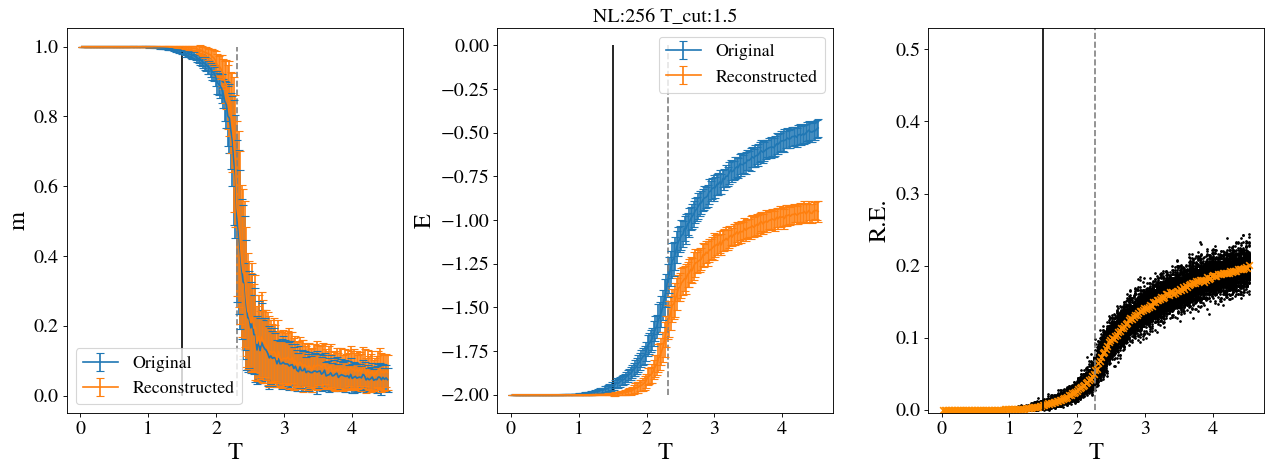

NL:512


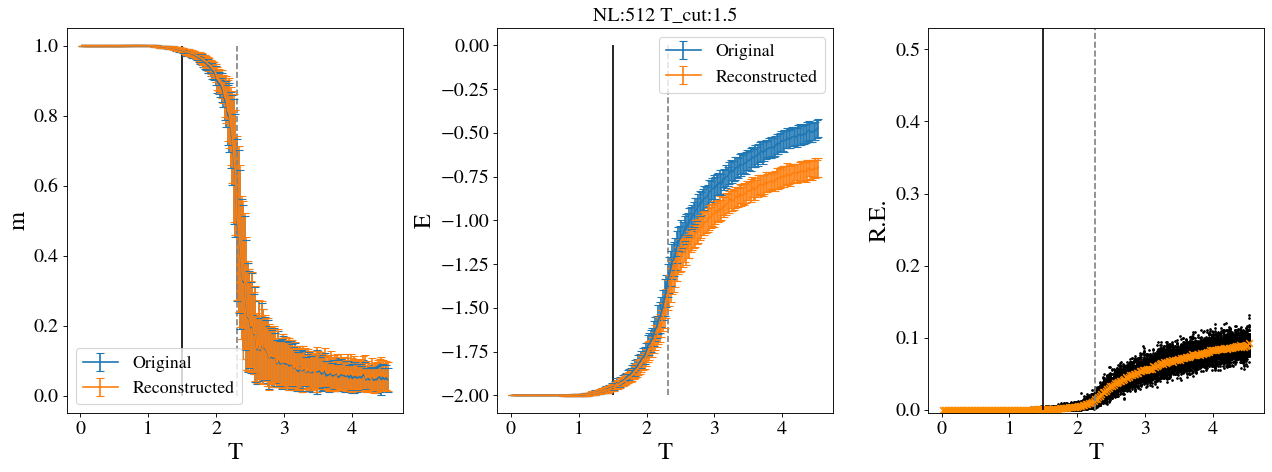

NL:1024


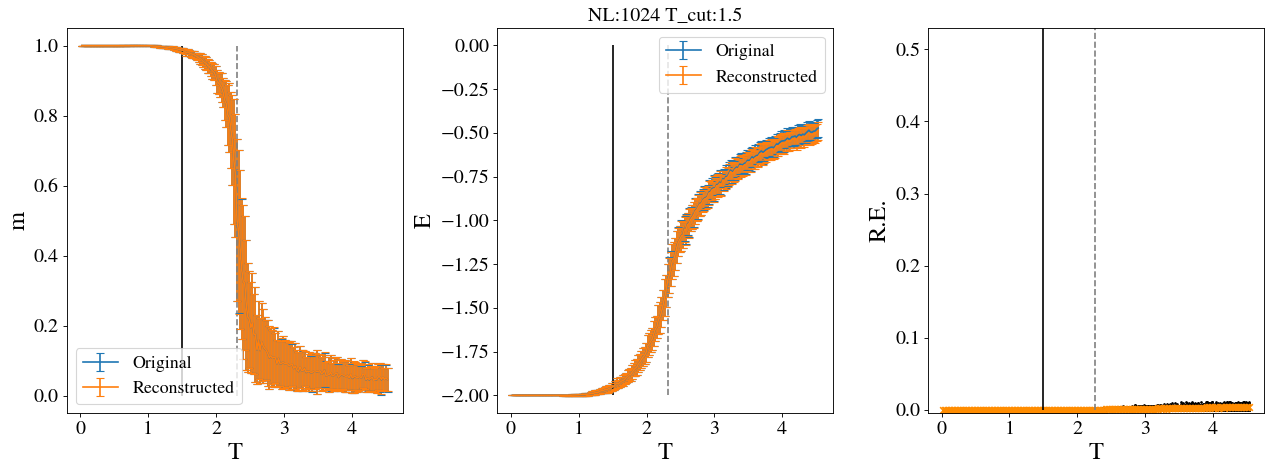

T_cut:2.0
NL:2


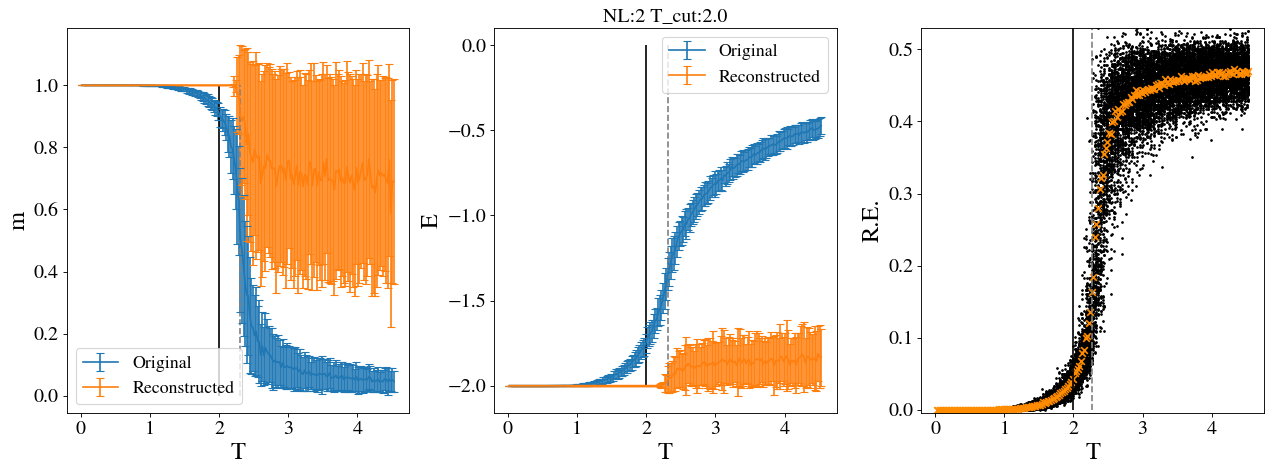

NL:4


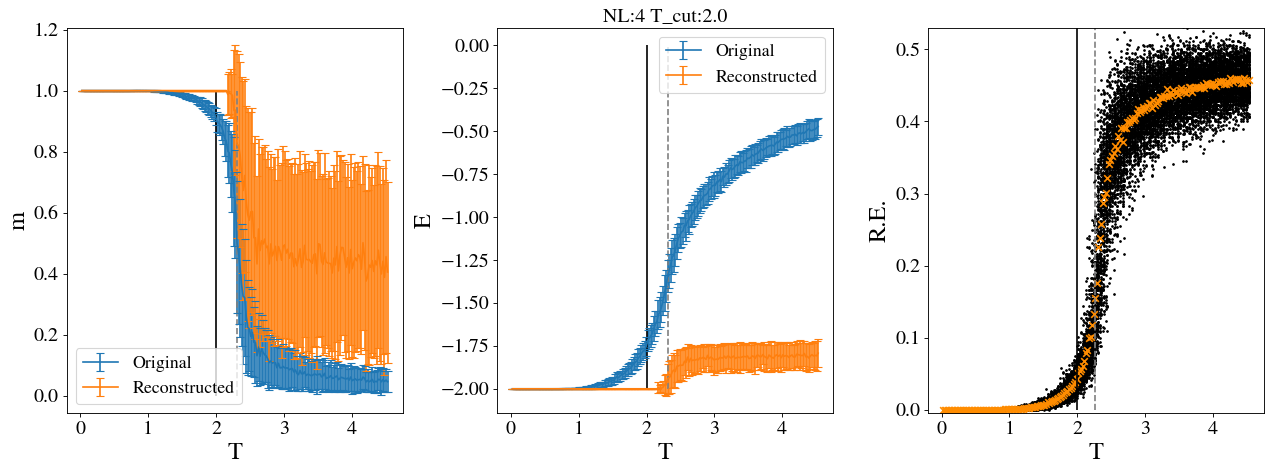

NL:8


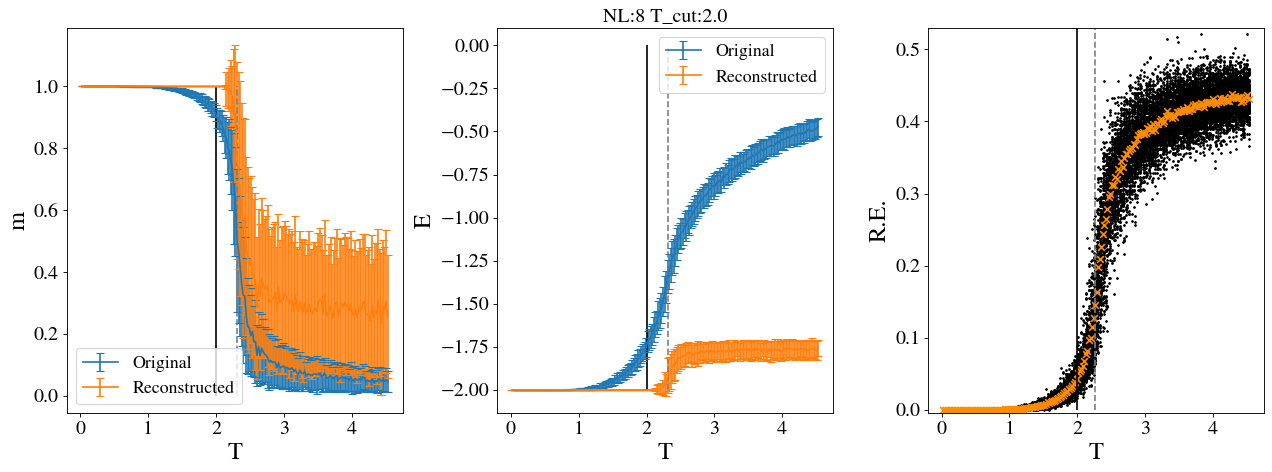

NL:16


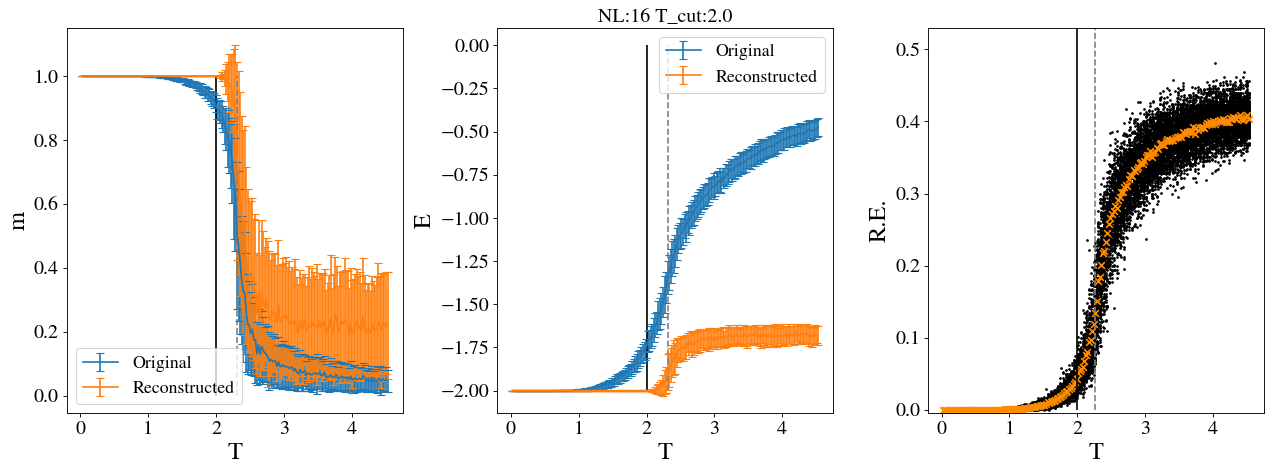

NL:32


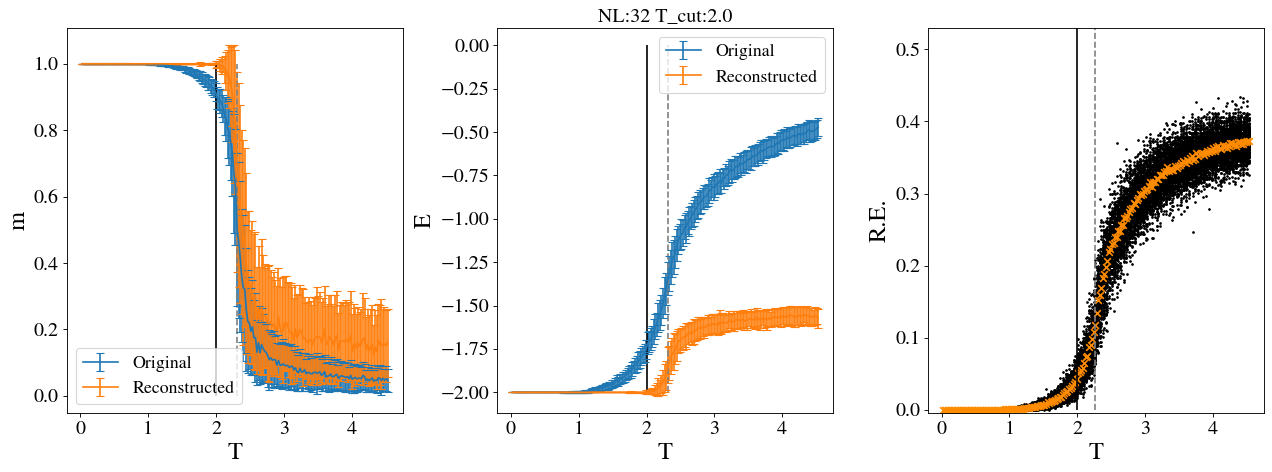

NL:64


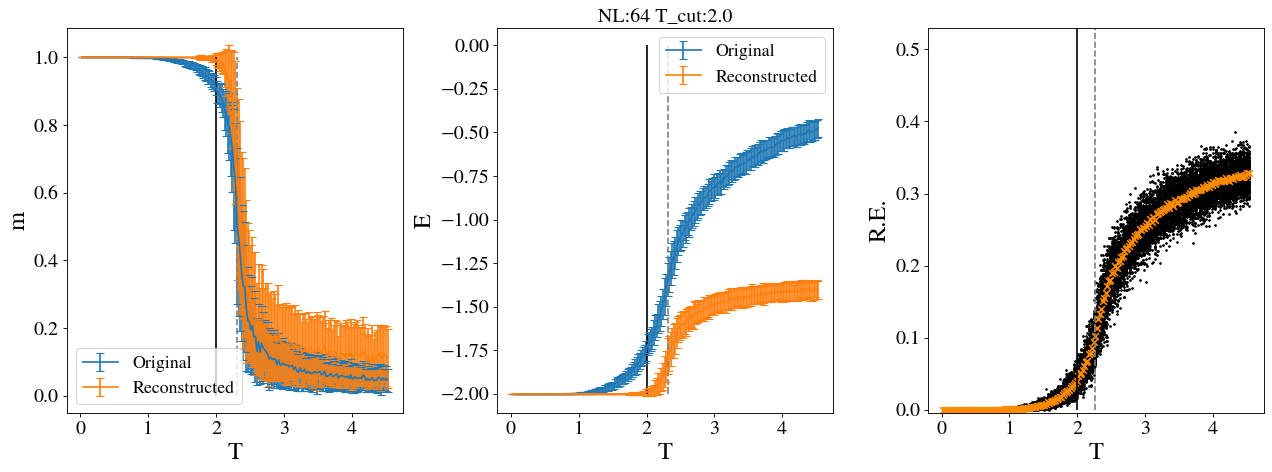

NL:128


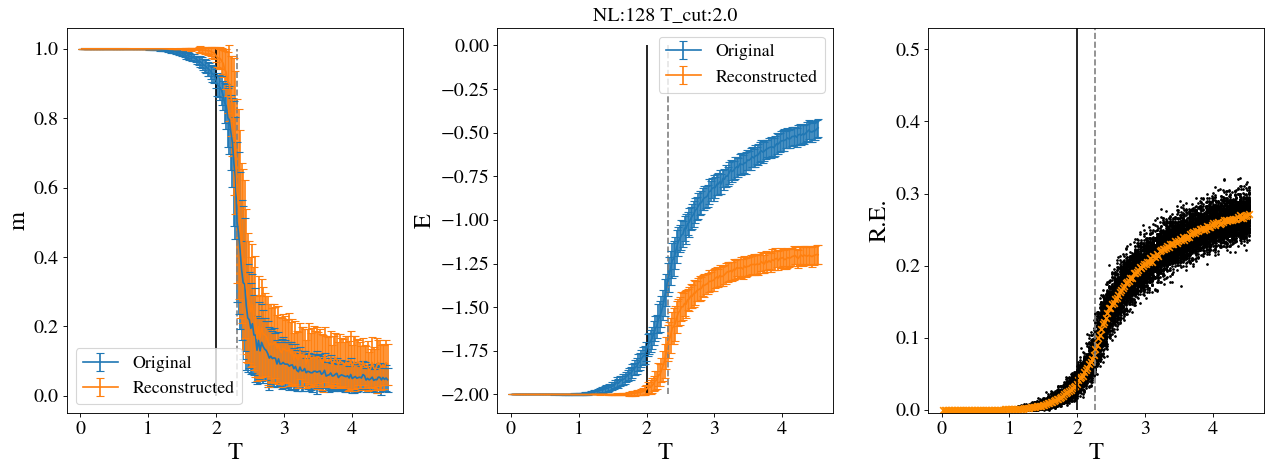

NL:256


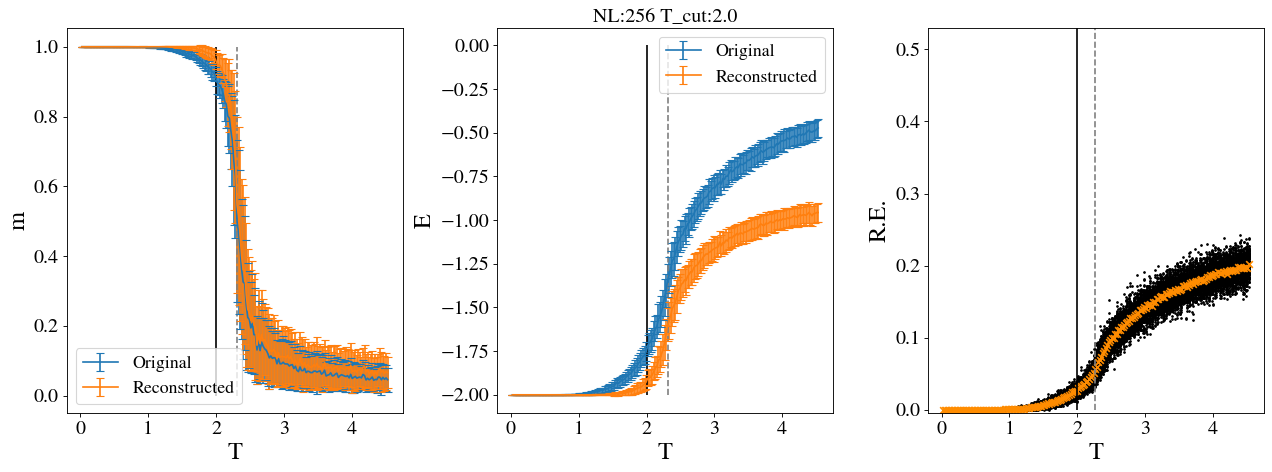

NL:512


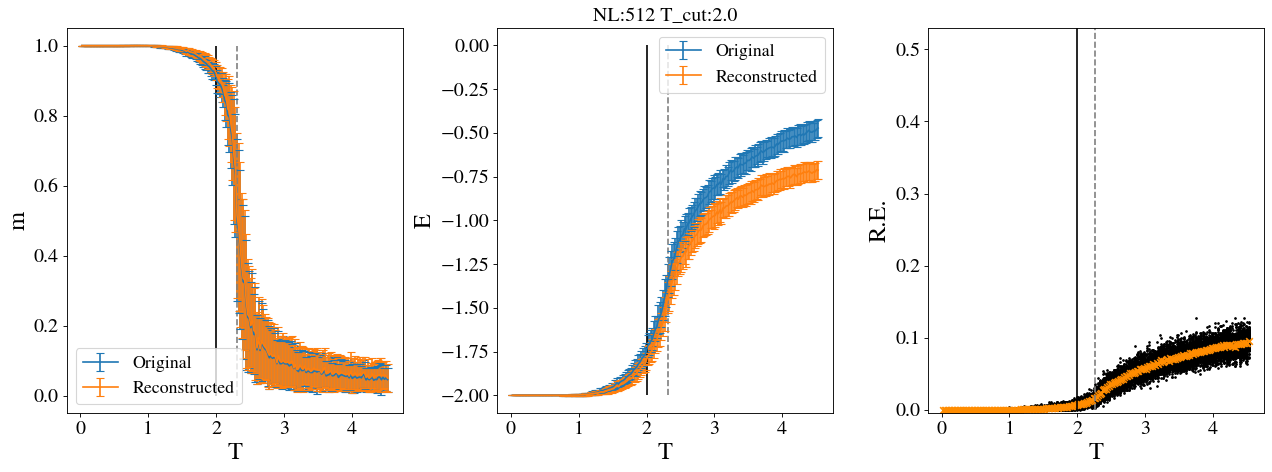

NL:1024


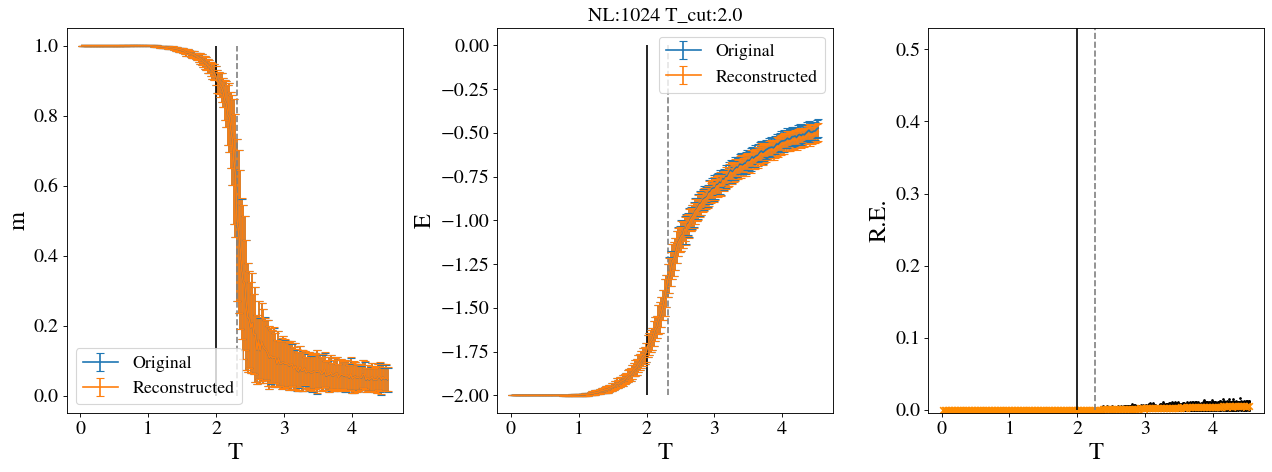

T_cut:2.5
NL:2


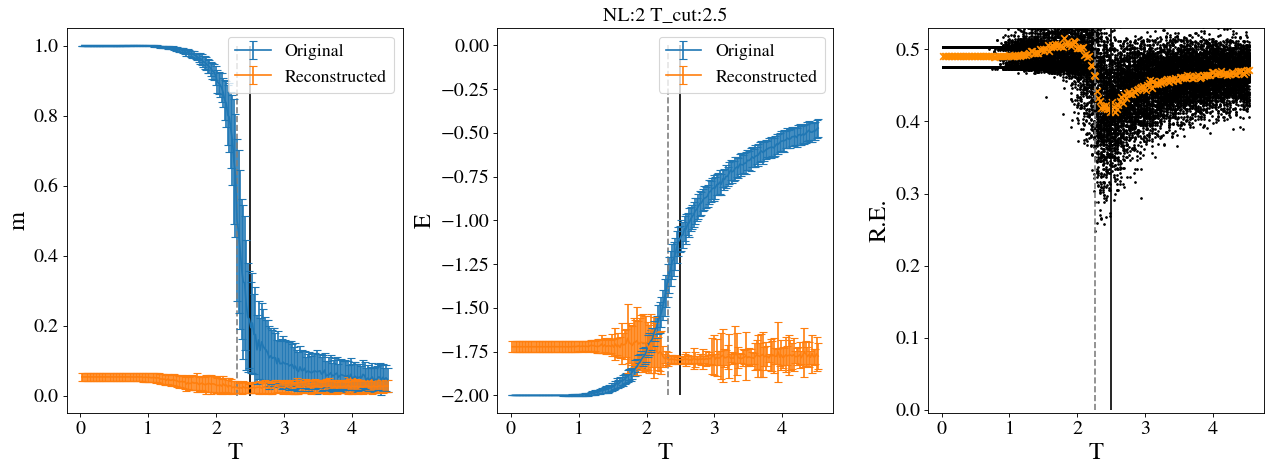

NL:4


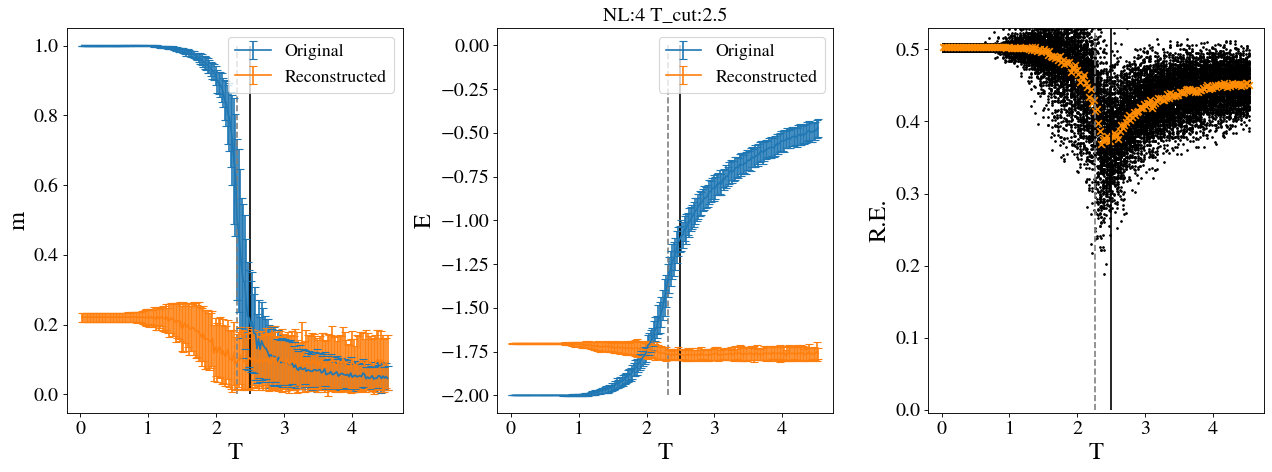

NL:8


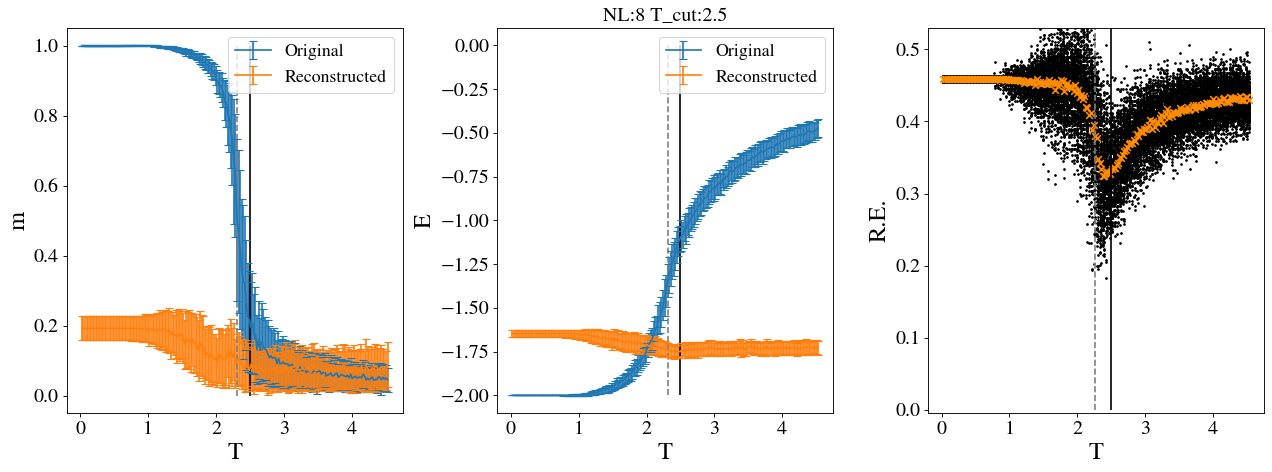

NL:16


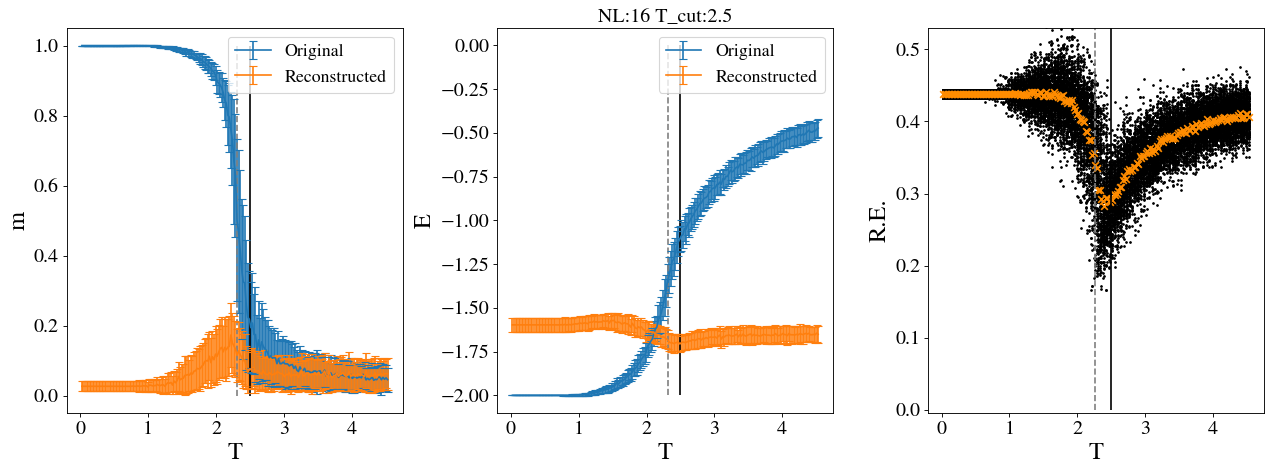

NL:32


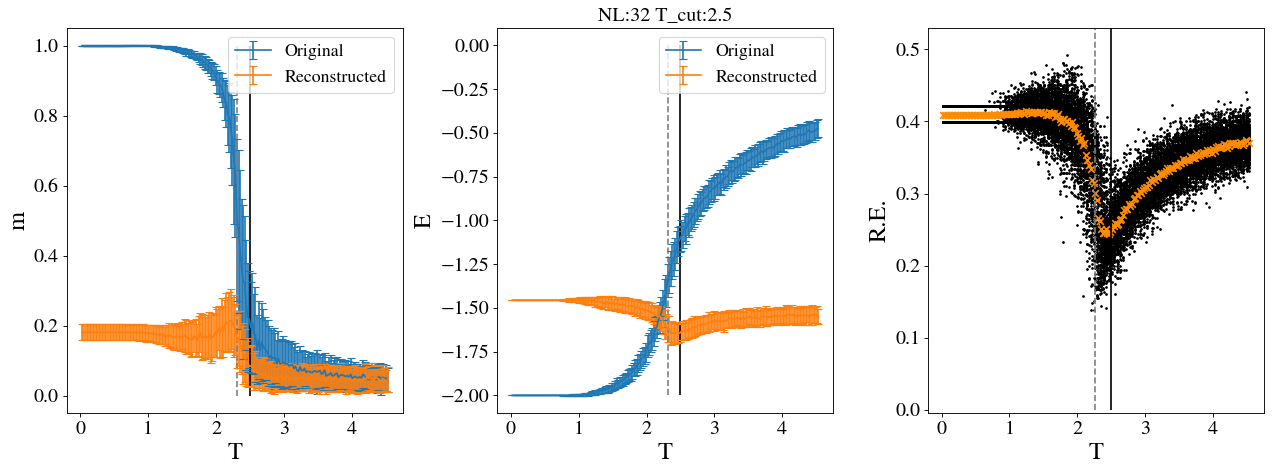

NL:64


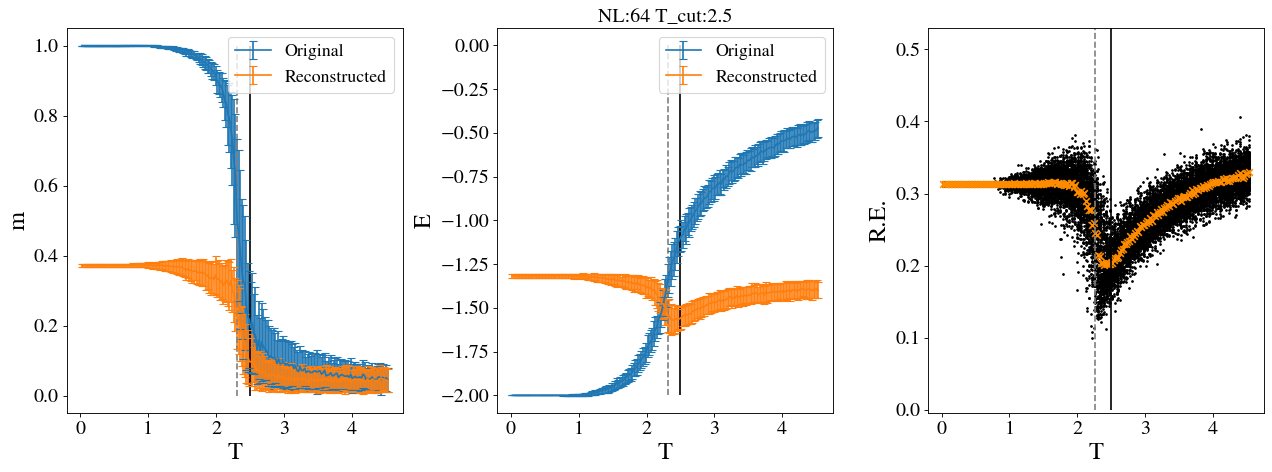

NL:128


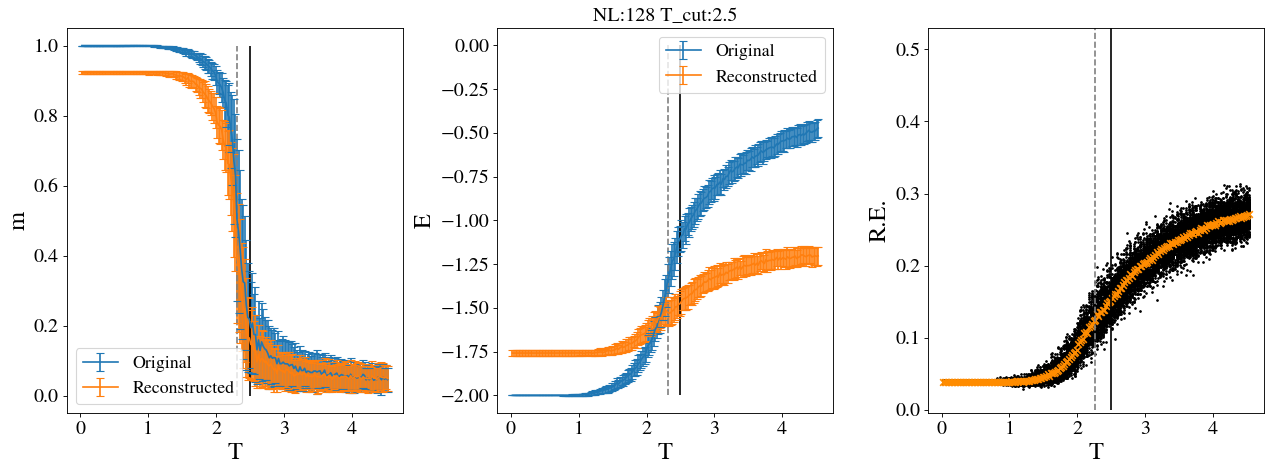

NL:256


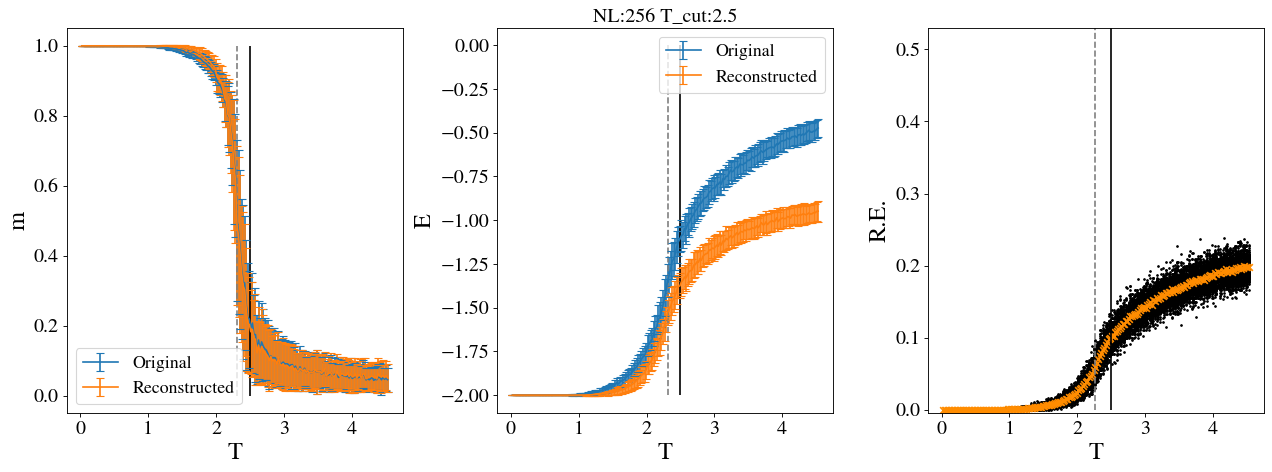

NL:512


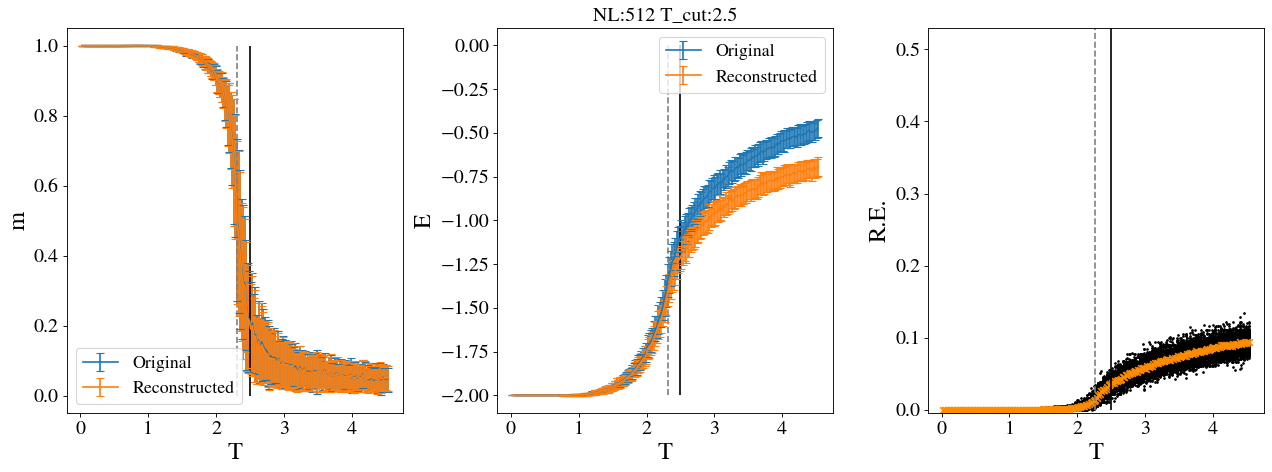

NL:1024


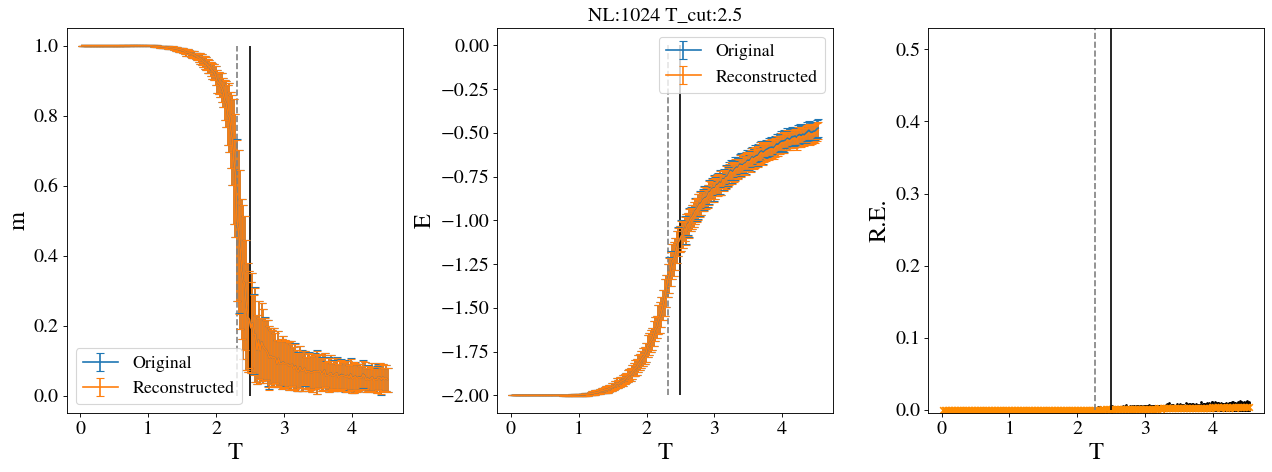

T_cut:3.0
NL:2


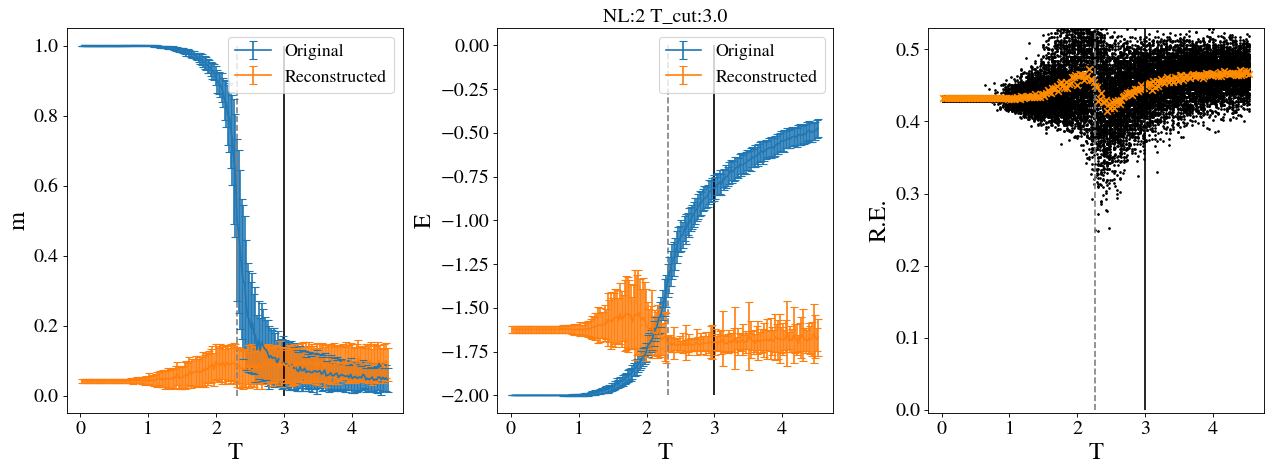

NL:4


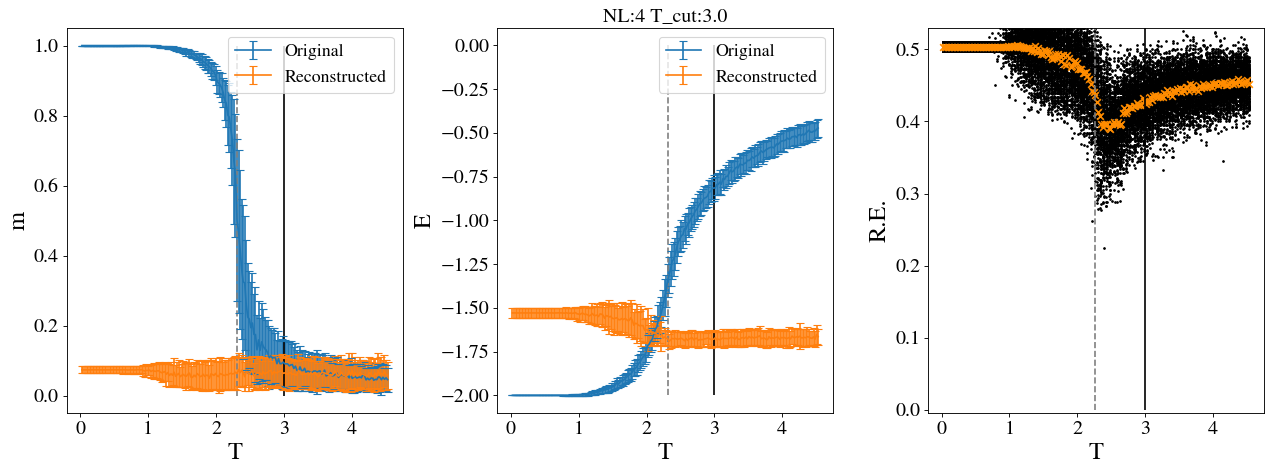

NL:8


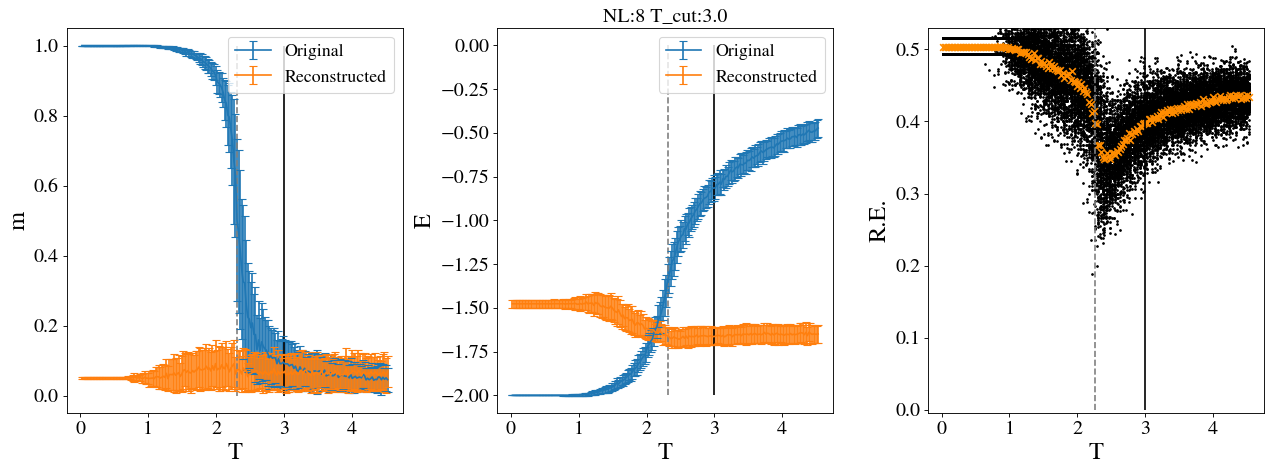

NL:16


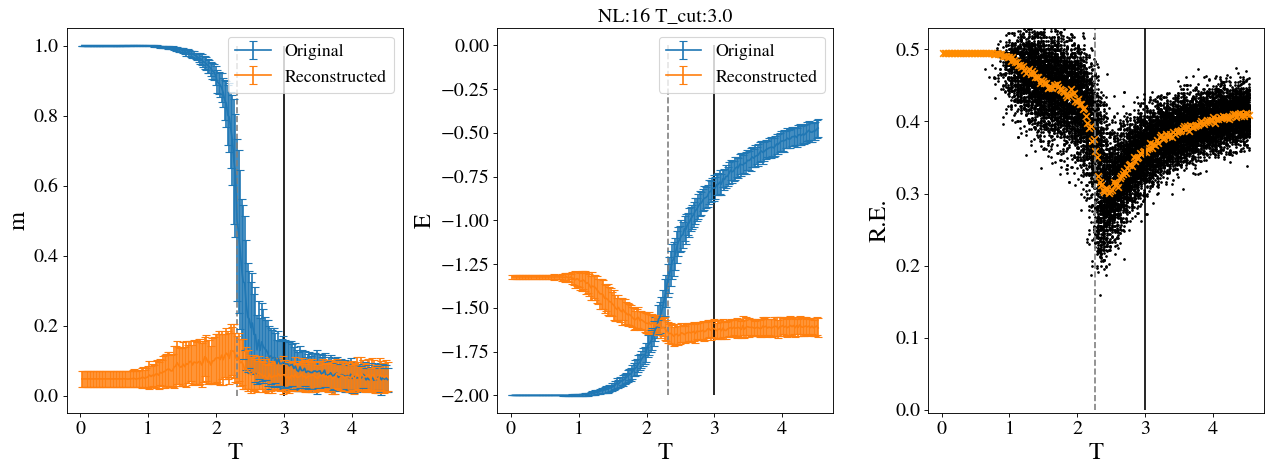

NL:32


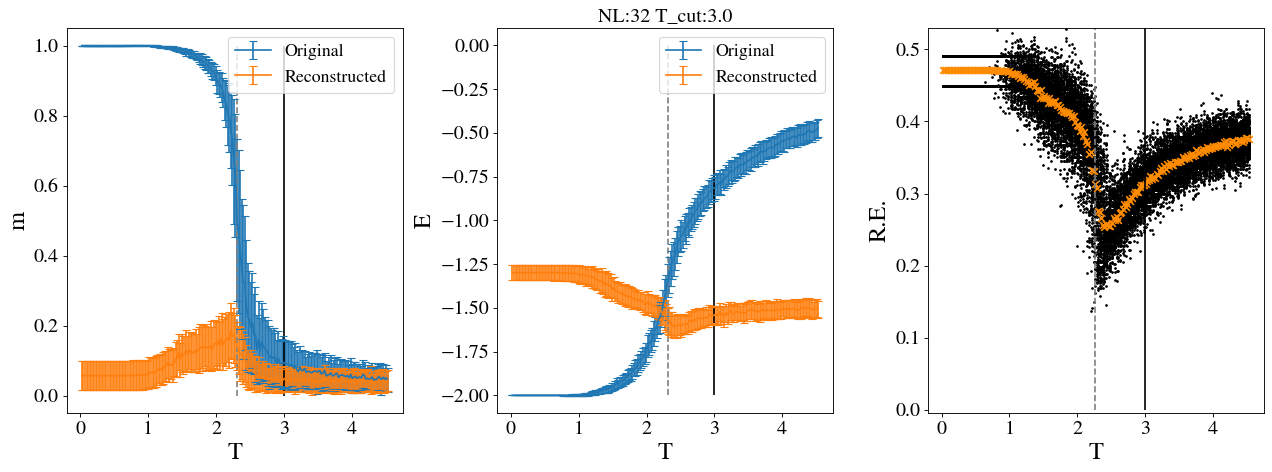

NL:64


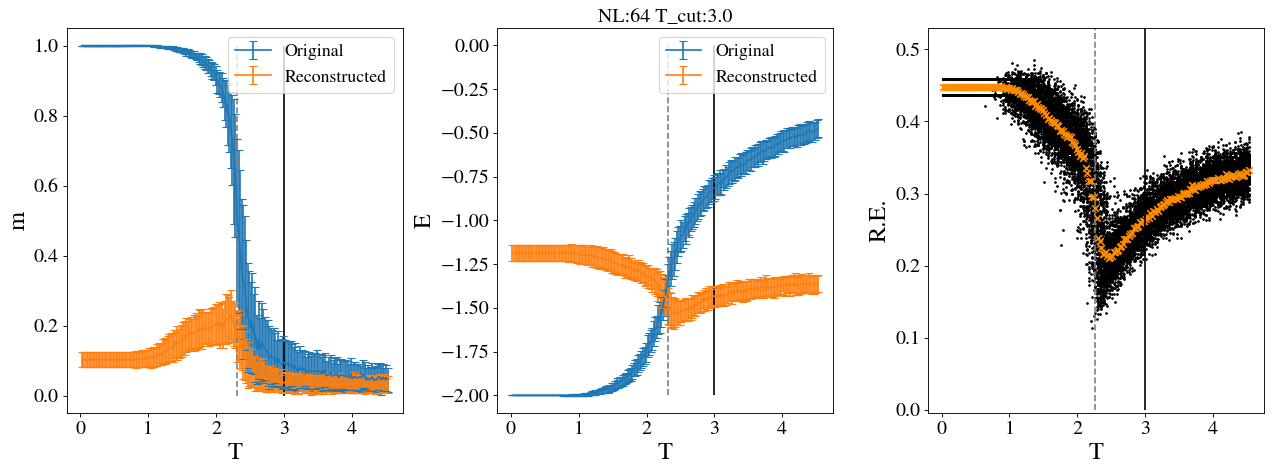

NL:128


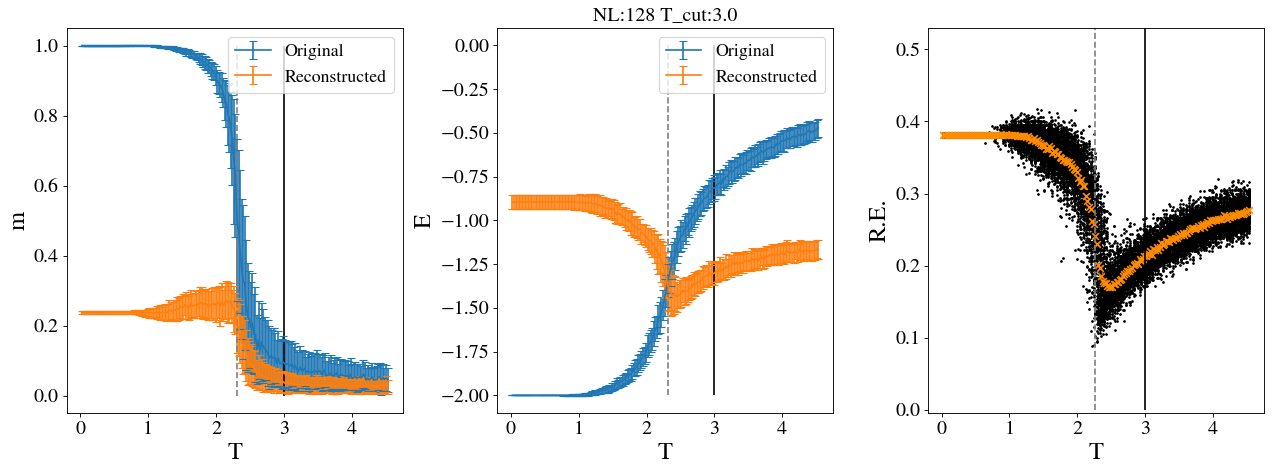

NL:256


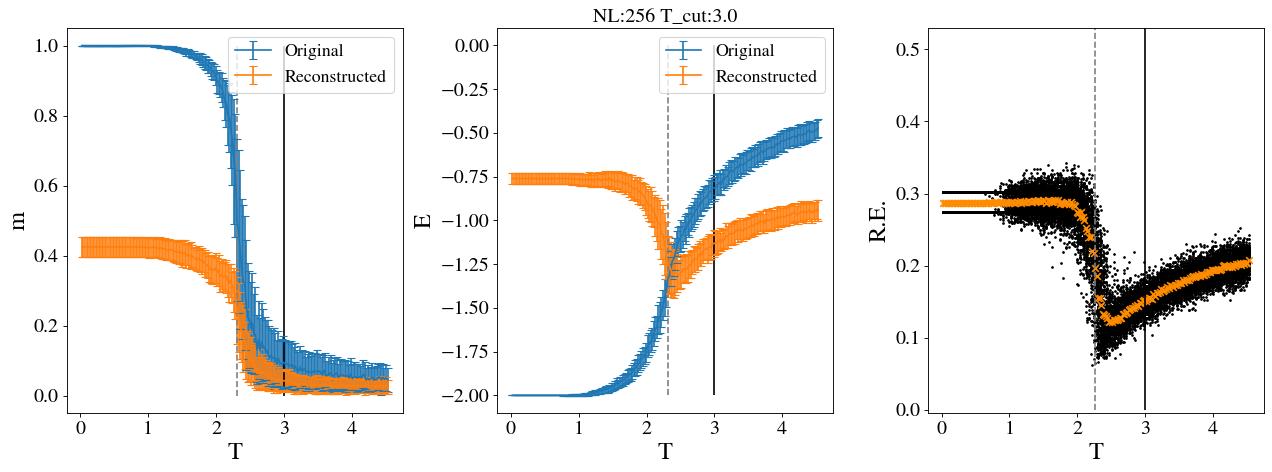

NL:512


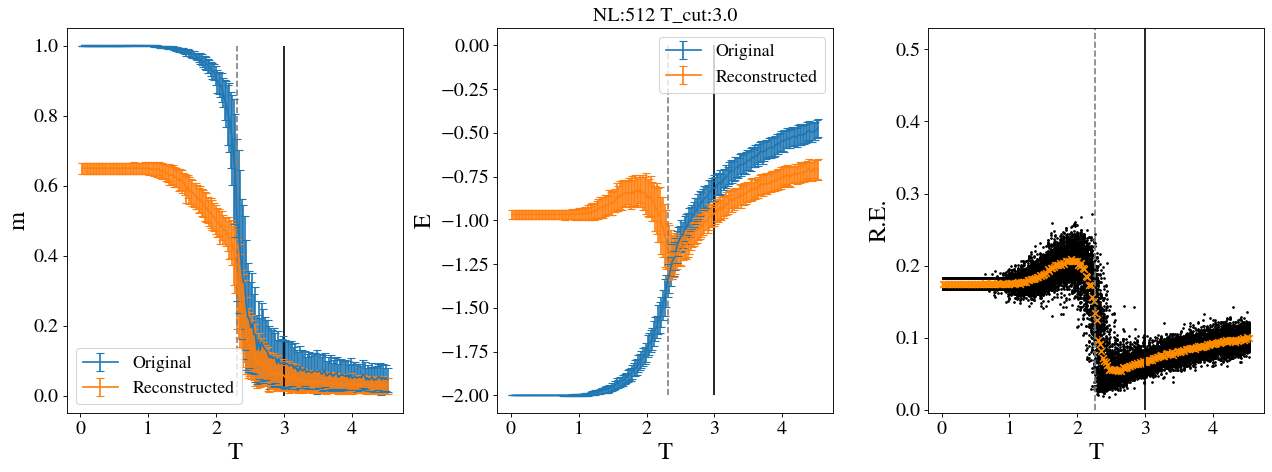

NL:1024


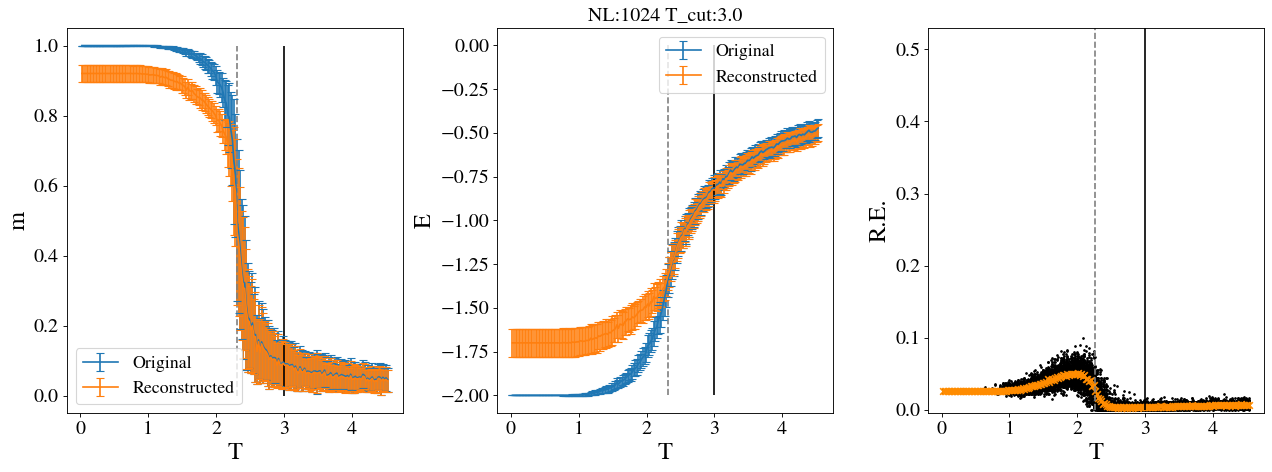

T_cut:3.5
NL:2


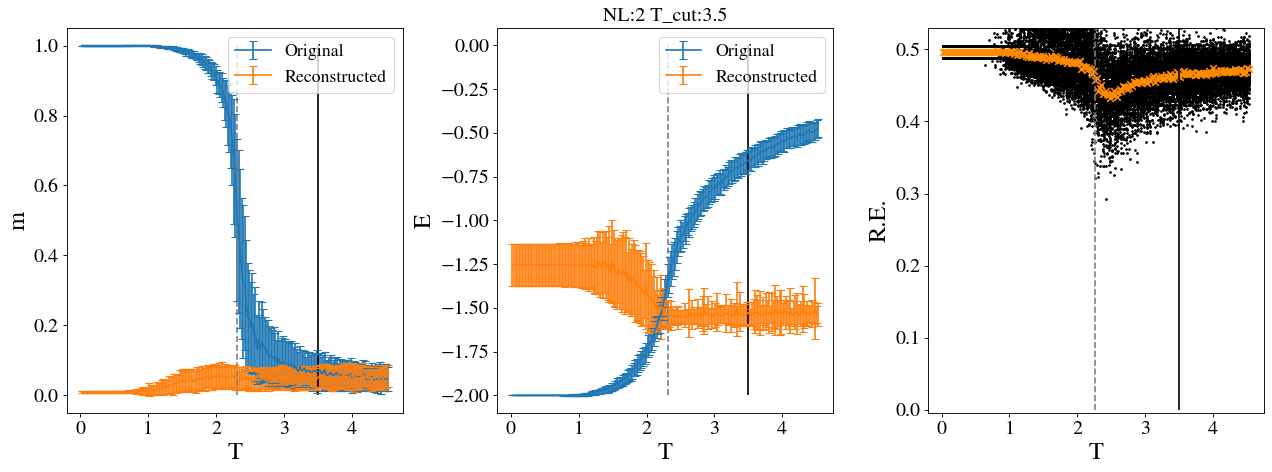

NL:4


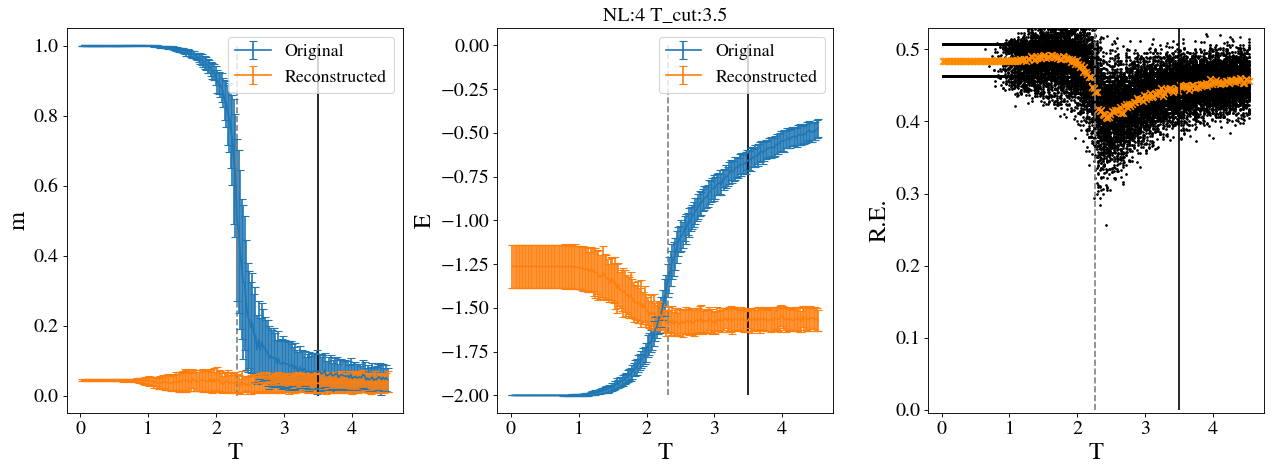

NL:8


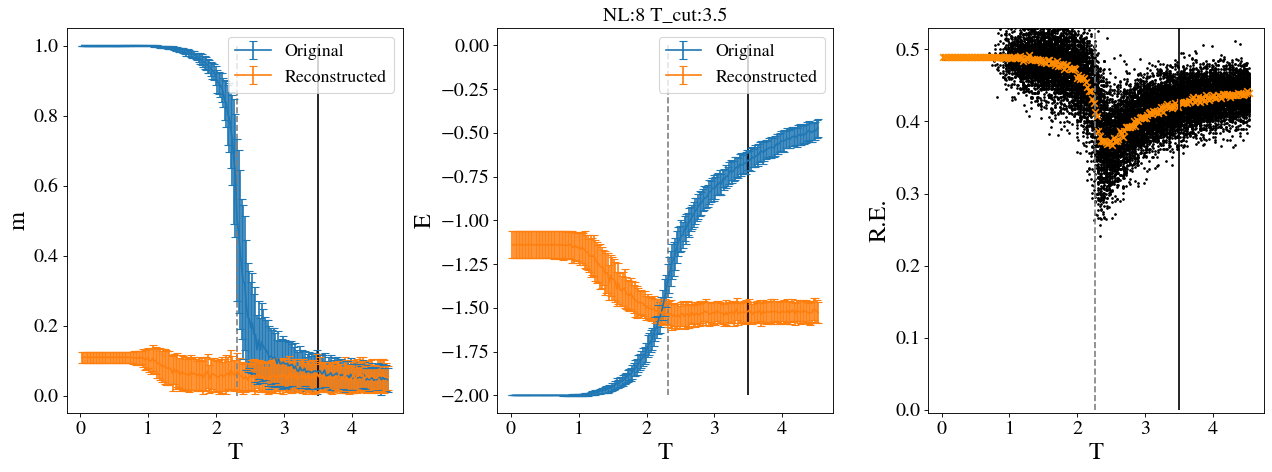

NL:16


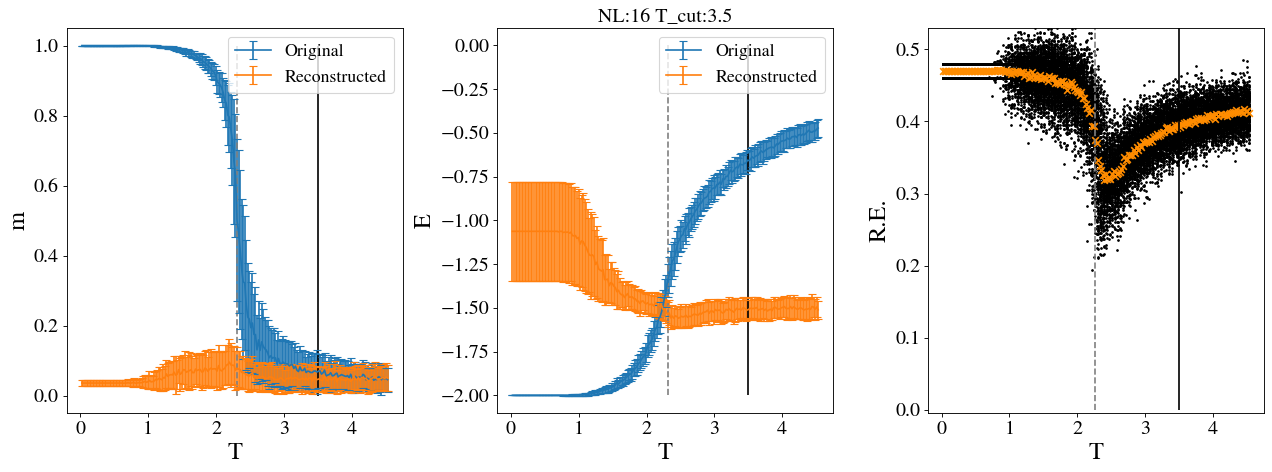

NL:32


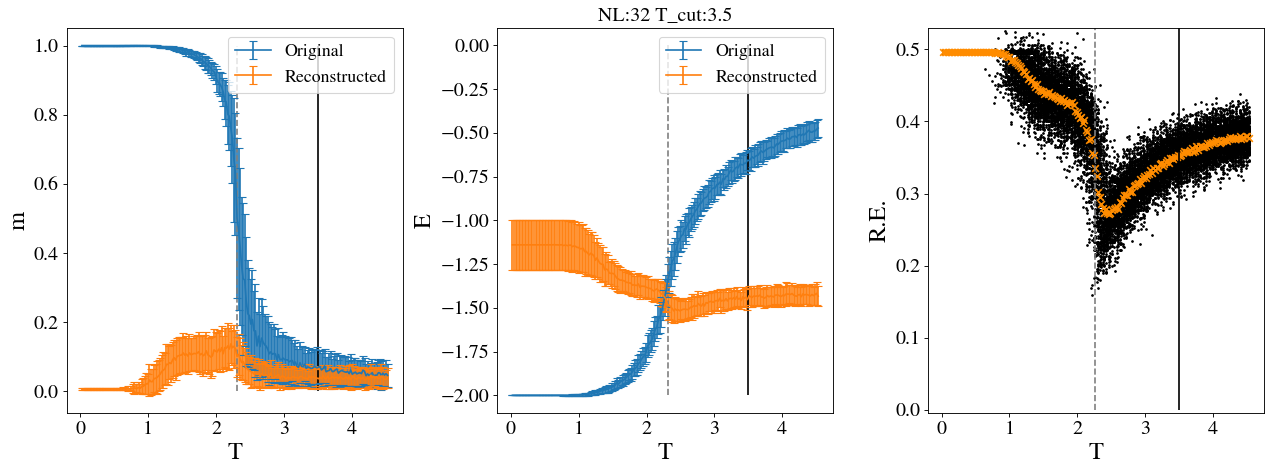

NL:64


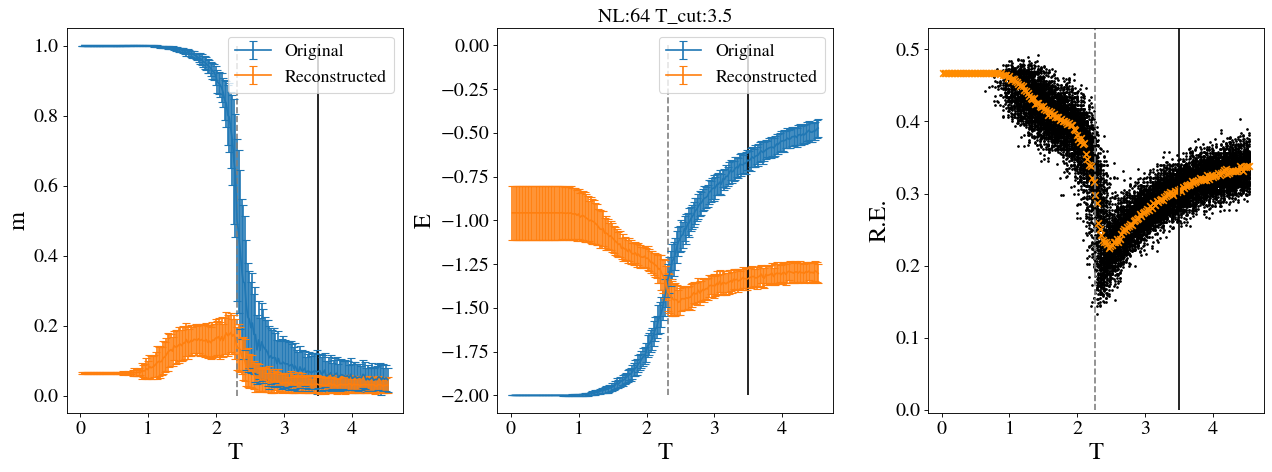

NL:128


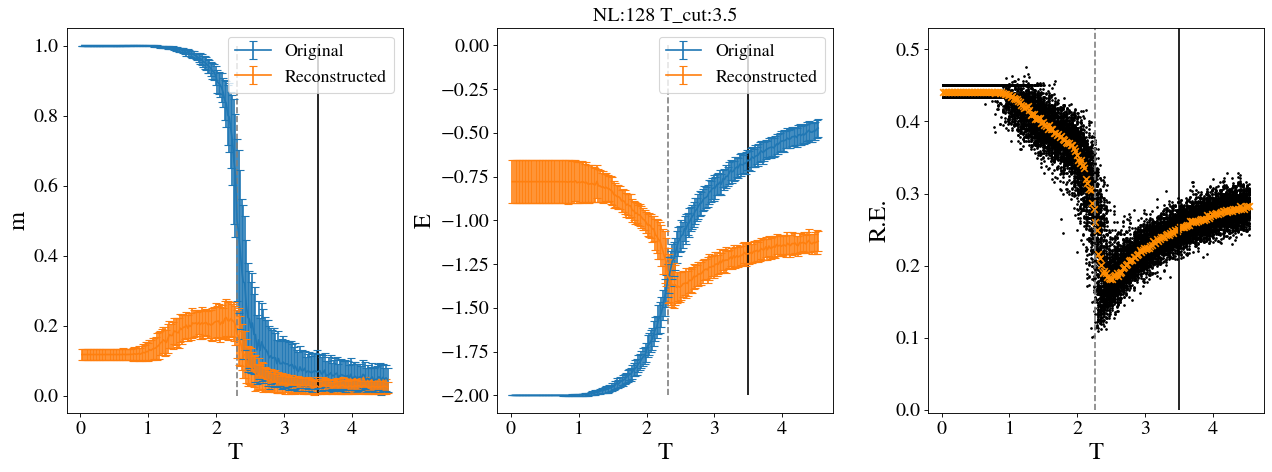

NL:256


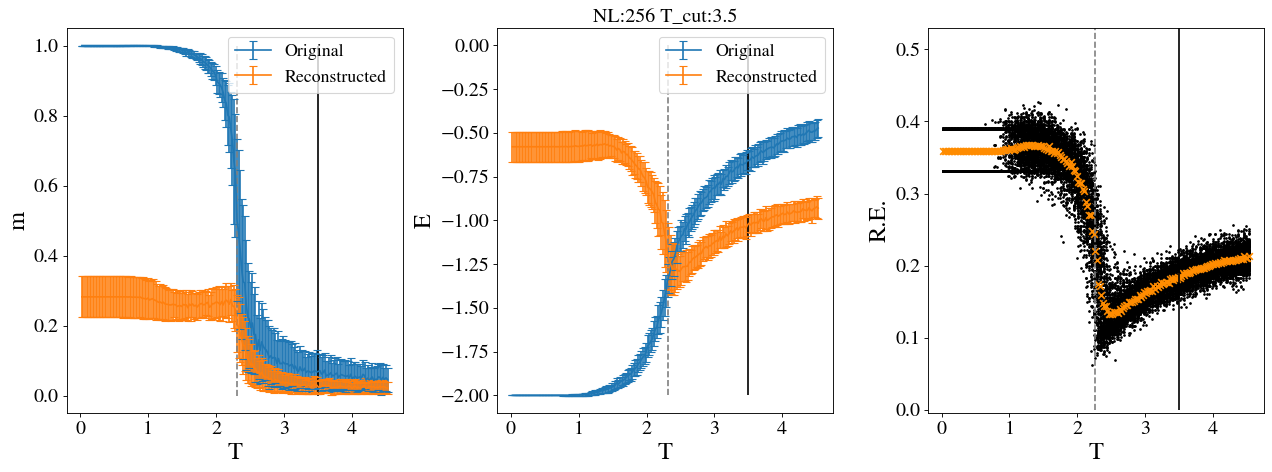

NL:512


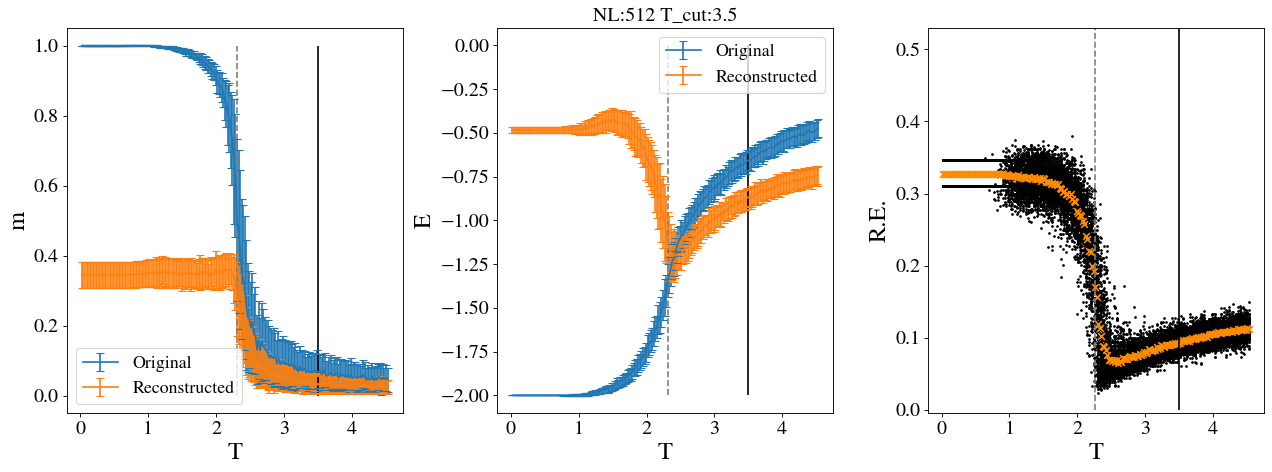

NL:1024


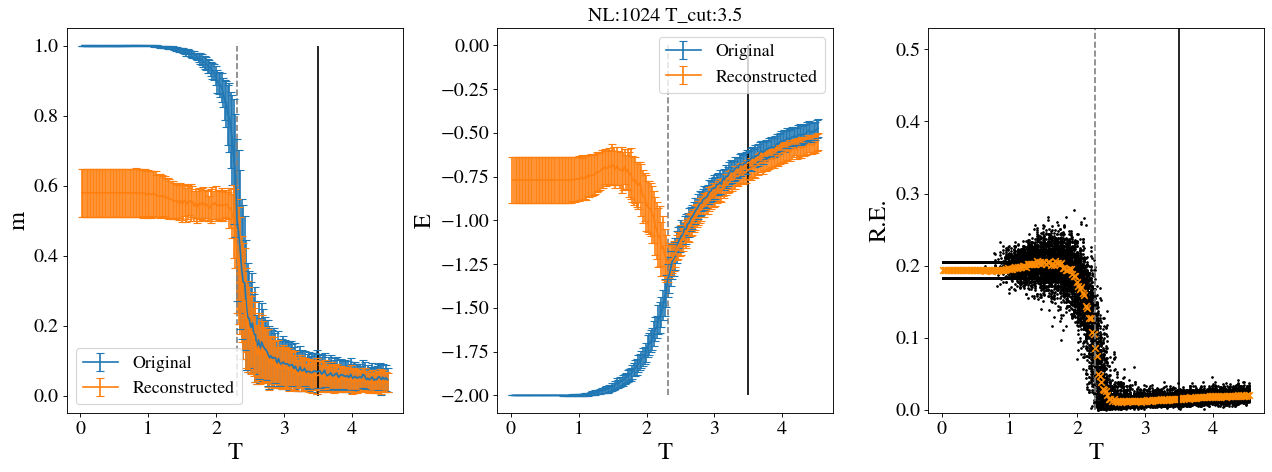

In [12]:
#load AE:
save_plot_flag=1
export_flag=1

T_cut_list=[1.5,2.0,2.5,3.0,3.5]
#NL_list=[32+4*i for i in range(35)] # number of neurons in the latent space
#NL_list.remove(32)
#NL_list.remove(64)
#NL_list.remove(128)
NL_list=[2**n for n in range(1,11)] # number of neurons in the latent space
NL_list.sort()

for T_cut in T_cut_list:
  print('T_cut:'+str(T_cut))
  for NL in NL_list:
    print('NL:'+str(NL))
    hyperparameters_txt='/L'+str(L)+'/NL'+str(NL)+'/DO'+str(Dropoutflag)+'/rl2'+str(rl2)+\
    '/BS'+str(BS)+'/epochs'+str(n_epochs)+'/lr'+str(lr)+'/'
    resultsfolder=path0+'/results'+hyperparameters_txt#folder where the results are saved
    os.makedirs(resultsfolder, exist_ok=True)
    modelfolder=path0+'/models'+hyperparameters_txt #folder where the models will be saved
    #load AE
    name_encoder='trained_encoder_T'+"{:.1f}".format(T_cut)+'.h5'
    name_decoder='trained_decoder_T'+"{:.1f}".format(T_cut)+'.h5'
    autoencoder=AEFullyConnected(NL,L,rl2)
    autoencoder.encoder = load_model(modelfolder+name_encoder, compile=False)
    autoencoder.decoder = load_model(modelfolder+name_decoder, compile=False)
    reconstructions_T=np.round(np.array([autoencoder.predict(x) for x in data_T]))
    #compute observables
    mag_T_r=[]
    E_T_r=[]
    for i in range(Class.n_T):
      mag_T_r.append([abs(r.mag(reconstructions_T[i][j],L)) for j in range(n_data)])
      E_T_r.append([r.Ener(reconstructions_T[i][j],L) for j in range(n_data)])
    #load RE 
    T_i=4.5
    RE_T=np.load(resultsfolder+'T_i'+"{:.1f}".format(T_i)+'/'+'RE_T'+"{:.1f}".format(T_cut)+'.npy')
    T_plot=[]
    n_data=np.shape(RE_T)[1]
    for i in range(Class.n_T):
      T_plot.append([Class.T[i]for j in range(n_data)])
    ###########m_vs_T
    plt.figure(figsize=(16, 6), dpi=80)
    plt.subplot(1, 3, 1)
    plt.errorbar(d.T[:d.n_T],np.mean(mag_T,axis=1),yerr=np.std(mag_T,axis=1),capsize=4,label='Original')
    plt.errorbar(d.T[:d.n_T],np.mean(mag_T_r,axis=1),yerr=np.std(mag_T_r,axis=1),capsize=4,label='Reconstructed')
    plt.xlabel('T',size=22)
    plt.ylabel('m',size=22)
    plt.vlines(d.T[d.n_Tc],0,1,color='gray',linestyles='dashed')
    plt.vlines(T_cut,0,1,color='black')
    plt.legend(prop={'size': 16})
    ###########E_vs_T
    plt.subplot(1, 3, 2)
    plt.title('NL:'+str(NL)+' T_cut:'+str(T_cut),size=18)
    plt.errorbar(d.T[:d.n_T],np.mean(E_T,axis=1),yerr=np.std(E_T,axis=1),capsize=4,label='Original')
    plt.errorbar(d.T[:d.n_T],np.mean(E_T_r,axis=1),yerr=np.std(E_T_r,axis=1),capsize=4,label='Reconstructed')
    plt.xlabel('T',size=22)
    plt.ylabel('E',size=22)
    plt.vlines(d.T[d.n_Tc],-2,0,color='gray',linestyles='dashed')
    plt.vlines(T_cut,-2,0,color='black')
    plt.legend( prop={'size': 16})
    ###########RE_vs_T
    plt.subplot(1, 3, 3)
    mean_RE_T=np.mean(RE_T,axis=1)
    plt.scatter(T_plot,RE_T,s=2,c='black')
    plt.scatter(Class.T[:Class.n_T],mean_RE_T,c='darkorange',marker='x')
    plt.xlabel('T',size=22)
    plt.ylabel('R.E.',size=22)
    plt.ylim([-0.005,0.53])
    plt.vlines(Tc,0,0.53,linestyles='dashed',color='grey')
    if (T_cut>0):
      plt.vlines(T_cut,0,0.53,color='black')
    plt.tight_layout()
    if save_plot_flag:
      figure_name=resultsfolder+'Reconstructed_m_E'+"{:.1f}".format(T_cut)+'.png' # for disordered initial_state
      plt.savefig(figure_name, bbox_inches='tight')
    plt.show()
    if export_flag:
      np.save(resultsfolder+'E_r_1_T'+str(T_cut),np.array(E_T_r))
      np.save(resultsfolder+'mag_r_1_T'+str(T_cut),np.array(mag_T_r))

T_cut:1.5
NL:16
NL:128
NL:256
NL:512


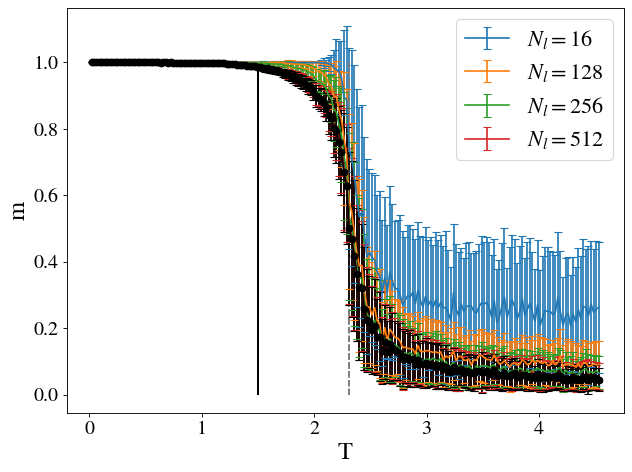

In [20]:
### PLOTS FOR PAPER

#load AE:
mag_flag=1

T_cut_list=[1.5]
#NL_list=[32+4*i for i in range(35)] # number of neurons in the latent space
#NL_list.remove(32)
#NL_list.remove(64)
#NL_list.remove(128)
#NL_list=[2**n for n in range(1,11)] # number of neurons in the latent space
#NL_list.sort()
NL_list=[16,64,128,256,512,1024]
NL_list=[16,128,256,512]


plt.figure(figsize=(8, 6), dpi=80)
for T_cut in T_cut_list:
  print('T_cut:'+str(T_cut))
  for NL in NL_list:
    print('NL:'+str(NL))
    hyperparameters_txt='/L'+str(L)+'/NL'+str(NL)+'/DO'+str(Dropoutflag)+'/rl2'+str(rl2)+\
    '/BS'+str(BS)+'/epochs'+str(n_epochs)+'/lr'+str(lr)+'/'
    resultsfolder=path0+'/results'+hyperparameters_txt#folder where the results are saved
    os.makedirs(resultsfolder, exist_ok=True)
    modelfolder=path0+'/models'+hyperparameters_txt #folder where the models will be saved
    #load reconstructed m and E 
    E_T_r=np.load(resultsfolder+'E_r_1_T'+str(T_cut)+'.npy')
    mag_T_r=np.load(resultsfolder+'mag_r_1_T'+str(T_cut)+'.npy')
    if mag_flag:
      ###########m_vs_T
      plt.errorbar(d.T[:d.n_T],np.mean(mag_T_r,axis=1),yerr=np.std(mag_T_r,axis=1),capsize=4,label=r'$N_l=$'+str(NL))
      plt.xlabel('T',size=22)
      plt.ylabel('m',size=22)
      plt.vlines(d.T[d.n_Tc],0,1,color='gray',linestyles='dashed')
      plt.vlines(T_cut,0,1,color='black')
      plt.legend(prop={'size': 20})
    else:
    ###########E_vs_T
      plt.errorbar(d.T[:d.n_T],np.mean(E_T_r,axis=1),yerr=np.std(E_T_r,axis=1),capsize=4,label=r'$N_l=$'+str(NL))
      plt.xlabel('T',size=22)
      plt.ylabel('E',size=22)
      plt.vlines(Tc,-2,0,color='gray',linestyles='dashed')
      plt.vlines(T_cut,-2,0,color='black')
      plt.legend( prop={'size': 20})


if mag_flag:
  plt.errorbar(d.T[:d.n_T],np.mean(mag_T,axis=1),yerr=np.std(mag_T,axis=1),fmt='o-',capsize=4,label='Original',color='black')
else:
  plt.errorbar(d.T[:d.n_T],np.mean(E_T,axis=1),yerr=np.std(E_T,axis=1),fmt='o-',capsize=4,label='Original',color='black')

plt.tight_layout()
plt.show()

## Thermodynamics

In [25]:
def thermal_f(data,n_T,initial_i,final_i,f,L):
  """ this function computes the thermal average and the standar deviation of a function f on data
  for each of the N_T temperatures
  the input of f must be a list of data with format (N_samples,L*L)
  Warning:
  final_i - initial_i must be a multiple of n_T
  """
  t_i=time.time()#initial_time
  n=final_i-initial_i
  mean=np.zeros(n_T) # list of means for the observable
  mean2=np.zeros(n_T) # list of means for the observable squared value
  for i in range(n):
    mean[(initial_i+i)%n_T]+=abs(f(data[i],L))
    mean2[(initial_i+i)%n_T]+=f(data[i],L)**2
  mean/=(n/n_T)
  mean2/=(n/n_T)
  std=mean2 - mean**2
  
  computing_time=round((time.time()-t_i)/60.,1)
  print("computing time: ",computing_time," minutes")
  return mean,std

n_T = 200
mean_op,chi=thermal_f(d.data,n_T,0,len(d.data),r.mag,L)
mean_e,Cv=thermal_f(d.data,n_T,0,len(d.data),r.Ener,L)

computing time:  2.0  minutes
computing time:  5.4  minutes


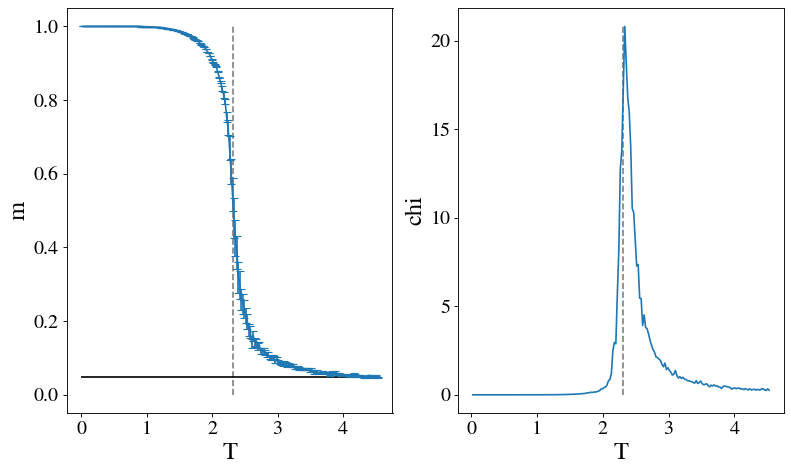

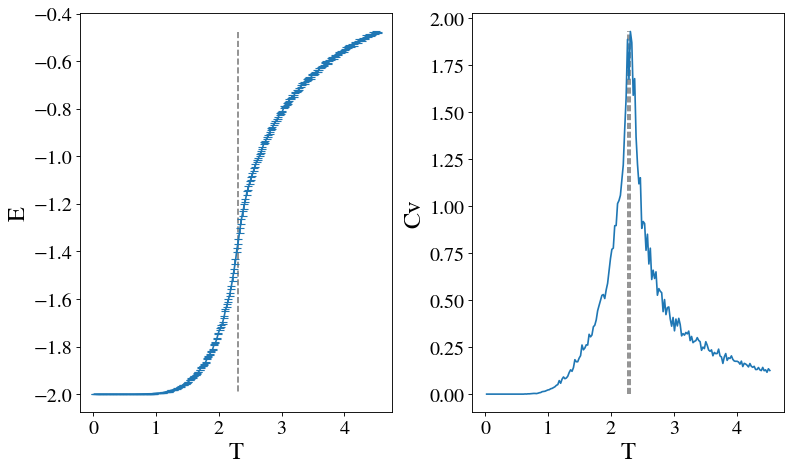

T_c magnetization: 0.5446166666666662 +- 1.9291011710473185
T_c Energy: -1.3584666666666676 +- 17.29076357327365
T_c:  2.3103
m(T=4.53): 0.04808888888888888


In [70]:
#Tc analitica:
Tc=2.27
n_Tc=98#Data ines:


#paths
file_path_e=os.getcwd()+'/termo/'+str(L)+'x'+str(L)+'mean_e_Tc.npy'
file_path_m=os.getcwd()+'/termo/'+str(L)+'x'+str(L)+'mean_m_Tc.npy'
file_path_Cv=os.getcwd()+'/termo/'+str(L)+'x'+str(L)+'mean_Cv_Tc.npy'
file_path_chi=os.getcwd()+'/termo/'+str(L)+'x'+str(L)+'mean_chi_Tc.npy'
#flags:
saveflag=0
loadflag=1
plotflag=1

if saveflag:
  np.save(file_path_e,mean_e)
  np.save(file_path_m,mean_op)
  np.save(file_path_Cv,Cv)
  np.save(file_path_chi,chi)
if loadflag:
  mean_e=np.load(file_path_e)
  mean_op=np.load(file_path_m)
  dispersion_E=np.load(file_path_Cv) 
  dispersion_m=np.load(file_path_chi) 
  
Cv=dispersion_E / np.array(d.T[:d.n_T])**2 * L**2
chi=dispersion_m / np.array(d.T[:d.n_T]) * L**2

if plotflag:
  plt.figure(figsize=(10, 6), dpi=80)
  plt.subplot(1, 2, 1)
  plt.errorbar(d.T[:d.n_T],mean_op,yerr=dispersion_m,capsize=4)
  plt.xlabel('T',size=22)
  plt.ylabel('m',size=22)
  plt.vlines(d.T[d.n_Tc],0,1,color='gray',linestyles='dashed')
  plt.hlines(mean_op[0],0,d.T[d.n_T],color='black')

  plt.subplot(1, 2, 2)
  plt.plot(d.T[:d.n_T],chi)
  plt.xlabel('T',size=22)
  plt.ylabel('chi',size=22)
  plt.vlines(d.T[d.n_Tc],min(chi),max(chi),color='gray',linestyles='dashed')
  plt.tight_layout()
  plt.show()

  plt.figure(figsize=(10, 6), dpi=80)
  plt.subplot(1, 2, 1)
  plt.errorbar(d.T[:d.n_T],-mean_e,yerr=dispersion_E,capsize=4)
  plt.xlabel('T',size=22)
  plt.ylabel('E',size=22)
  plt.vlines(d.T[d.n_Tc],max(-mean_e),min(-mean_e),color='gray',linestyles='dashed')

  plt.subplot(1, 2, 2)
  plt.plot(d.T[:d.n_T],Cv)
  plt.xlabel('T',size=22)
  plt.ylabel('Cv',size=22)
  #plt.vlines(d.T[d.n_Tc],min(Cv),max(Cv),color='gray',linestyles='dashed')
  plt.vlines(Tc,min(Cv),max(Cv),color='gray',linestyles='dashed')
  plt.tight_layout()
  plt.show()

  print('T_c magnetization:', mean_op[d.n_Tc], '+-',Cv[d.n_Tc])
  print('T_c Energy:', -mean_e[d.n_Tc],'+-',chi[d.n_Tc])
  print('T_c: ',d.T[d.n_Tc])
  print('m(T=4.53):',mean_op[0])